In [47]:
import numpy as np 
import pandas as pd 

import os
cnt = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if(cnt < 20):
            print(os.path.join(dirname, filename))
            cnt += 1

/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv
/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv
/kaggle/input/child-mind-institute-problematic-internet-use/train.csv
/kaggle/input/child-mind-institute-problematic-internet-use/test.csv
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=00115b9f/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=001f3379/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0745c390/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=eaab7a96/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=8ec2cc63/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=b2987a65/part-0.parquet
/kaggle/input/child-mind-institute-problematic-intern

## LOADING LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


## LOADING DATASET

In [3]:
train = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")
train.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [5]:
train.describe(include = "all")

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
count,3960,3960,3960.000000,3960.000000,2555,2421.000000,3310,3022.000000,3027.000000,3076.000000,...,2728.000000,2730.000000,2733.000000,2736.000000,2618,2609.000000,2606.000000,3540,3301.000000,2736.000000
unique,3960,4,NaN,NaN,4,NaN,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4,NaN,NaN,4,NaN,NaN
top,00008ff9,Spring,NaN,NaN,Spring,NaN,Spring,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Spring,NaN,NaN,Spring,NaN,NaN
freq,1,1127,NaN,NaN,697,NaN,929,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,712,NaN,NaN,985,NaN,NaN
mean,NaN,NaN,10.433586,0.372727,NaN,65.454771,NaN,19.331929,55.946713,89.038615,...,1.613636,1.158974,0.943652,27.896199,NaN,41.088923,57.763622,NaN,1.060588,0.580409
std,NaN,NaN,3.574648,0.483591,NaN,22.341862,NaN,5.113934,7.473764,44.569040,...,1.529178,1.343661,1.185460,20.338853,NaN,10.427433,13.196091,NaN,1.094875,0.771122
min,NaN,NaN,5.000000,0.000000,NaN,25.000000,NaN,0.000000,33.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,NaN,17.000000,38.000000,NaN,0.000000,0.000000
25%,NaN,NaN,8.000000,0.000000,NaN,59.000000,NaN,15.869350,50.000000,57.200000,...,0.000000,0.000000,0.000000,12.000000,NaN,33.000000,47.000000,NaN,0.000000,0.000000
50%,NaN,NaN,10.000000,0.000000,NaN,65.000000,NaN,17.937682,55.000000,77.000000,...,1.000000,1.000000,1.000000,26.000000,NaN,39.000000,55.000000,NaN,1.000000,0.000000
75%,NaN,NaN,13.000000,1.000000,NaN,75.000000,NaN,21.571244,62.000000,113.800000,...,2.000000,2.000000,1.000000,41.000000,NaN,46.000000,64.000000,NaN,2.000000,1.000000


In [6]:
test = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")
test.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   Basic_Demos-Enroll_Season               20 non-null     object 
 2   Basic_Demos-Age                         20 non-null     int64  
 3   Basic_Demos-Sex                         20 non-null     int64  
 4   CGAS-Season                             10 non-null     object 
 5   CGAS-CGAS_Score                         8 non-null      float64
 6   Physical-Season                         14 non-null     object 
 7   Physical-BMI                            13 non-null     float64
 8   Physical-Height                         13 non-null     float64
 9   Physical-Weight                         13 non-null     float64
 10  Physical-Waist_Circumference            5 non-null      float64


### PROCESSING TIME SERIES DATASET 

In [8]:
t = pd.read_parquet("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=7800a084/part-0.parquet")
t.head()
print(t.describe())
print(t.describe().values.reshape(-1))
del t

                step              X              Y              Z  \
count  440316.000000  440316.000000  440316.000000  440316.000000   
mean   220157.500000      -0.415238      -0.032251      -0.205879   
std    127108.424902       0.471411       0.417656       0.561340   
min         0.000000      -1.979738      -2.831392      -1.039866   
25%    110078.750000      -0.809919      -0.277351      -0.718729   
50%    220157.500000      -0.539259      -0.042334      -0.238490   
75%    330236.250000      -0.074829       0.217732       0.212457   
max    440315.000000       1.200500       1.881267       2.280875   

                enmo         anglez  non-wear_flag          light  \
count  440316.000000  440316.000000  440316.000000  440316.000000   
mean        0.039228     -15.597169       0.010220      36.810112   
std         0.081368      40.512878       0.098523     162.750900   
min         0.000000     -89.719704       0.000000       0.000000   
25%         0.000223     -47.5339

In [9]:
# Reading a Parquet file, and returns descriptive statistics along with an identifier(id)

def process_file(filename: str , dirname: str)-> tuple:
    df = pd.read_parquet(os.path.join(dirname,filename,'part-0.parquet'))
    df.drop('step', axis = 1, inplace = True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

In [10]:
#Load time series data from directory and process each file 
# and return after aggregating results into dataframe 

def load_time_series(dirname:str)->pd.DataFrame:
    files = os.listdir(dirname) #gets all the files in dirname
    
    with ThreadPoolExecutor() as executor:
        result_iter = executor.map(lambda filename: process_file(filename,dirname), files) # map process over each item in files list 
                                                                                           # and compute the lambda func which takes each filename of the files list as input
        result_progress = tqdm(result_iter, total = len(files)) #to see the progress bar
        result = list(result_progress) #format->tuple->(([1.2, 3.4, 5.6], 'file_1'))
    statistics, indexes = zip(*result) # unwrap tuples and then aggregate all statistical results in 'statistics' & aggregate all indexes in 'indexes'
    
    df = pd.DataFrame(statistics, columns = [f"stat_{i}" for i in range(len(statistics[0]))])   # create DF with 'describe' statistics like mean,mas... as column
                                                                                                # for each parquet files(996)
    df['id'] = indexes #index (its matched with csv files)

    return df
    

In [11]:
train_time_series = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_time_series = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00,  7.55it/s]


In [12]:
train_time_series.head()

,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,...,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,id
0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,...,5.314874,89.422226,0.0,2626.199951,4187.0,8.639500e+13,7.0,2.0,57.0,0745c390
1,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,...,3.966906,89.080330,1.0,2628.199951,4146.0,8.639500e+13,7.0,2.0,243.0,eaab7a96
2,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,...,5.066334,86.987267,0.0,2618.199951,4183.0,8.636500e+13,7.0,3.0,134.0,8ec2cc63
3,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,...,6.134459,89.976074,0.0,2502.000000,6000.0,8.639500e+13,7.0,4.0,72.0,b2987a65
4,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,...,2.774382,89.300034,0.0,1046.800049,4199.0,8.601500e+13,7.0,4.0,76.0,7b8842c3


(time series features X describe()) = (12 X 8) = 96 ---> [stat_0,    stat_1,   	stat_2,  	stat_3,  	stat_4,   ...   stat_93,  	stat_94,  	stat_95]

In [13]:
train_time_series.describe()

,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,...,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
count,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,...,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,9.960000e+02,996.000000,996.000000,996.000000
mean,315832.478916,315832.478916,315832.478916,315832.478916,315832.478916,315832.478916,315832.478916,315832.478916,315832.478916,315832.478916,...,1.875645,3.674156,88.888246,0.650602,2335.652809,4180.122239,8.628980e+13,6.933735,2.615462,78.834337
std,133011.574731,133011.574731,133011.574731,133011.574731,133011.574731,133011.574731,133011.574731,133011.574731,133011.574731,133011.574731,...,0.911899,1.459785,3.313411,0.477019,898.044846,93.299368,8.984971e+11,0.504877,1.158635,86.447984
min,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,...,0.167161,0.140138,11.565893,0.000000,26.500000,3996.000000,6.980500e+13,2.000000,1.000000,-119.000000
25%,253592.750000,253592.750000,253592.750000,253592.750000,253592.750000,253592.750000,253592.750000,253592.750000,253592.750000,253592.750000,...,1.230632,2.790156,88.972979,0.000000,2512.600098,4170.000000,8.639500e+13,7.000000,2.000000,30.000000
50%,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,...,1.740934,3.806256,89.377281,1.000000,2613.625000,4180.000000,8.639500e+13,7.000000,3.000000,51.000000
75%,402597.000000,402597.000000,402597.000000,402597.000000,402597.000000,402597.000000,402597.000000,402597.000000,402597.000000,402597.000000,...,2.234637,4.593709,89.651743,1.000000,2637.000000,4187.000000,8.639500e+13,7.000000,4.000000,90.000000
max,756212.000000,756212.000000,756212.000000,756212.000000,756212.000000,756212.000000,756212.000000,756212.000000,756212.000000,756212.000000,...,8.125557,11.326200,89.981140,1.000000,20445.500000,6000.000000,8.639500e+13,7.000000,4.000000,748.000000


In [14]:
train_time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 97 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   stat_0   996 non-null    float64
 1   stat_1   996 non-null    float64
 2   stat_2   996 non-null    float64
 3   stat_3   996 non-null    float64
 4   stat_4   996 non-null    float64
 5   stat_5   996 non-null    float64
 6   stat_6   996 non-null    float64
 7   stat_7   996 non-null    float64
 8   stat_8   996 non-null    float64
 9   stat_9   996 non-null    float64
 10  stat_10  996 non-null    float64
 11  stat_11  996 non-null    float64
 12  stat_12  996 non-null    float64
 13  stat_13  996 non-null    float64
 14  stat_14  996 non-null    float64
 15  stat_15  996 non-null    float64
 16  stat_16  996 non-null    float64
 17  stat_17  996 non-null    float64
 18  stat_18  996 non-null    float64
 19  stat_19  996 non-null    float64
 20  stat_20  996 non-null    float64
 21  stat_21  996 non

In [15]:
test_time_series.head()

,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,...,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,id
0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,...,4.004276,89.751656,0.0,2633.250000,4188.5,8.611000e+13,7.0,3.0,85.0,00115b9f
1,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,...,2.952888,89.476036,1.0,2597.800049,4175.0,8.639500e+13,7.0,3.0,91.0,001f3379


In [16]:
test_time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 97 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   stat_0   2 non-null      float64
 1   stat_1   2 non-null      float64
 2   stat_2   2 non-null      float64
 3   stat_3   2 non-null      float64
 4   stat_4   2 non-null      float64
 5   stat_5   2 non-null      float64
 6   stat_6   2 non-null      float64
 7   stat_7   2 non-null      float64
 8   stat_8   2 non-null      float64
 9   stat_9   2 non-null      float64
 10  stat_10  2 non-null      float64
 11  stat_11  2 non-null      float64
 12  stat_12  2 non-null      float64
 13  stat_13  2 non-null      float64
 14  stat_14  2 non-null      float64
 15  stat_15  2 non-null      float64
 16  stat_16  2 non-null      float64
 17  stat_17  2 non-null      float64
 18  stat_18  2 non-null      float64
 19  stat_19  2 non-null      float64
 20  stat_20  2 non-null      float64
 21  stat_21  2 non-null 

### MERGING PHYSICAL AND TIME SERIES DATASET

In [17]:
train = pd.merge(train,train_time_series,how = "left", on = "id")
test = pd.merge(test,test_time_series,how = "left", on = "id")

In [18]:
train.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,1.546979,4.004276,89.751656,0.0,2633.25,4188.5,8.611000e+13,7.0,3.0,85.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Columns: 178 entries, id to stat_95
dtypes: float64(164), int64(2), object(12)
memory usage: 5.4+ MB


In [20]:
train.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,1.546979,4.004276,89.751656,0.0,2633.25,4188.5,8.611000e+13,7.0,3.0,85.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Columns: 155 entries, id to stat_95
dtypes: float64(142), int64(2), object(11)
memory usage: 24.3+ KB


## DATA PREPROCESSING & EDA

In [22]:
#to exclude the columns in training set but not in test set as it ain't helping in prediction
columns_train = []
for column in train.columns:
    columns_train.append(column)
    
columns_test = []
for column in test.columns:
    columns_test.append(column)
    
common_columns = [] 
for column in columns_train:
    if column in columns_test:
        common_columns.append(column)
common_columns.append('sii')

exclude_columns = []
for column in columns_train:
    if column not in common_columns:
        exclude_columns.append(column)

train = train[common_columns]
print("Columns that are excluded from training set: ")
print(exclude_columns)
del exclude_columns


Columns that are excluded from training set: 
['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total']


In [23]:
#deleting variable that are no longer in use.
del columns_train
del columns_test
del common_columns
del test_time_series
del train_time_series

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Columns: 156 entries, id to sii
dtypes: float64(143), int64(2), object(11)
memory usage: 4.7+ MB


In [25]:
train = train.drop(columns=['id']) 
test = test.drop(columns=['id'])

In [26]:
#checking no. of NAN values in each columns
total_examples = len(train)
temp = pd.DataFrame(train.isnull().sum(), columns = ['NULL'])
temp['%NULL'] = (temp['NULL']*100)/total_examples
print(temp.sort_values('%NULL', ascending = False))
print(temp[temp.index.str.contains('sii', case=False, na=False)]) #explicitly checking null entries in target feature


                             NULL      %NULL
PAQ_A-Season                 3485  88.005051
PAQ_A-PAQ_A_Total            3485  88.005051
Fitness_Endurance-Time_Sec   3220  81.313131
Fitness_Endurance-Time_Mins  3220  81.313131
Fitness_Endurance-Max_Stage  3217  81.237374
...                           ...        ...
FGC-Season                    614  15.505051
PreInt_EduHx-Season           420  10.606061
Basic_Demos-Age                 0   0.000000
Basic_Demos-Sex                 0   0.000000
Basic_Demos-Enroll_Season       0   0.000000

[155 rows x 2 columns]
     NULL      %NULL
sii  1224  30.909091


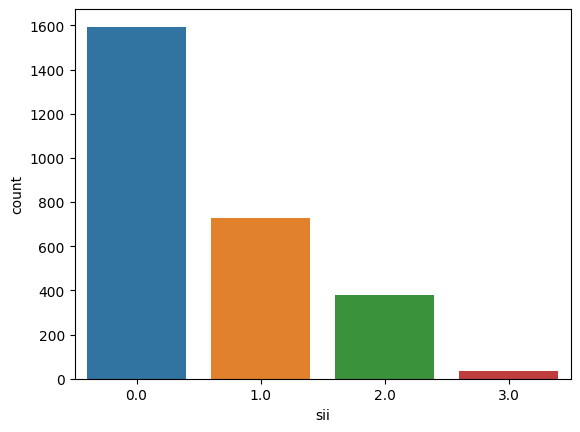

In [27]:
#counting no. of distinct types of sii values
sns.countplot(x='sii', data = train)
plt.show()

In [28]:
train = train.dropna(subset = 'sii')
train = train.reset_index(drop = True)
train.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,sii
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,...,4.004276,89.751656,0.0,2633.250000,4188.5,8.611000e+13,7.0,3.0,85.0,1.0
4,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,NaN,...,2.952888,89.476036,1.0,2597.800049,4175.0,8.639500e+13,7.0,3.0,91.0,1.0


In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Columns: 155 entries, Basic_Demos-Enroll_Season to sii
dtypes: float64(143), int64(2), object(10)
memory usage: 3.2+ MB


In [30]:
#Extracting numeric and categorical columns 

 #train dataset
numeric_cols = list(train.select_dtypes(exclude = ['object']).columns.difference(['sii'])) #remove target column if target column is in the list
categorical_cols = list(train.select_dtypes(include =['object']).columns)

#test dataset
test_numeric_cols = list(test.select_dtypes(exclude = ['object']).columns)
test_categorical_cols = list(test.select_dtypes(include =['object']).columns)

In [31]:
print(len(numeric_cols))
print(numeric_cols)

144
['BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'Physical-BMI', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Height', 'Physical-Systolic_BP', 'Physical-Waist_Circumference', 'Physical-Weight', 'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'stat_0', 'stat_1', 'stat_10', 'stat_11', 'stat_12', 'stat_13'

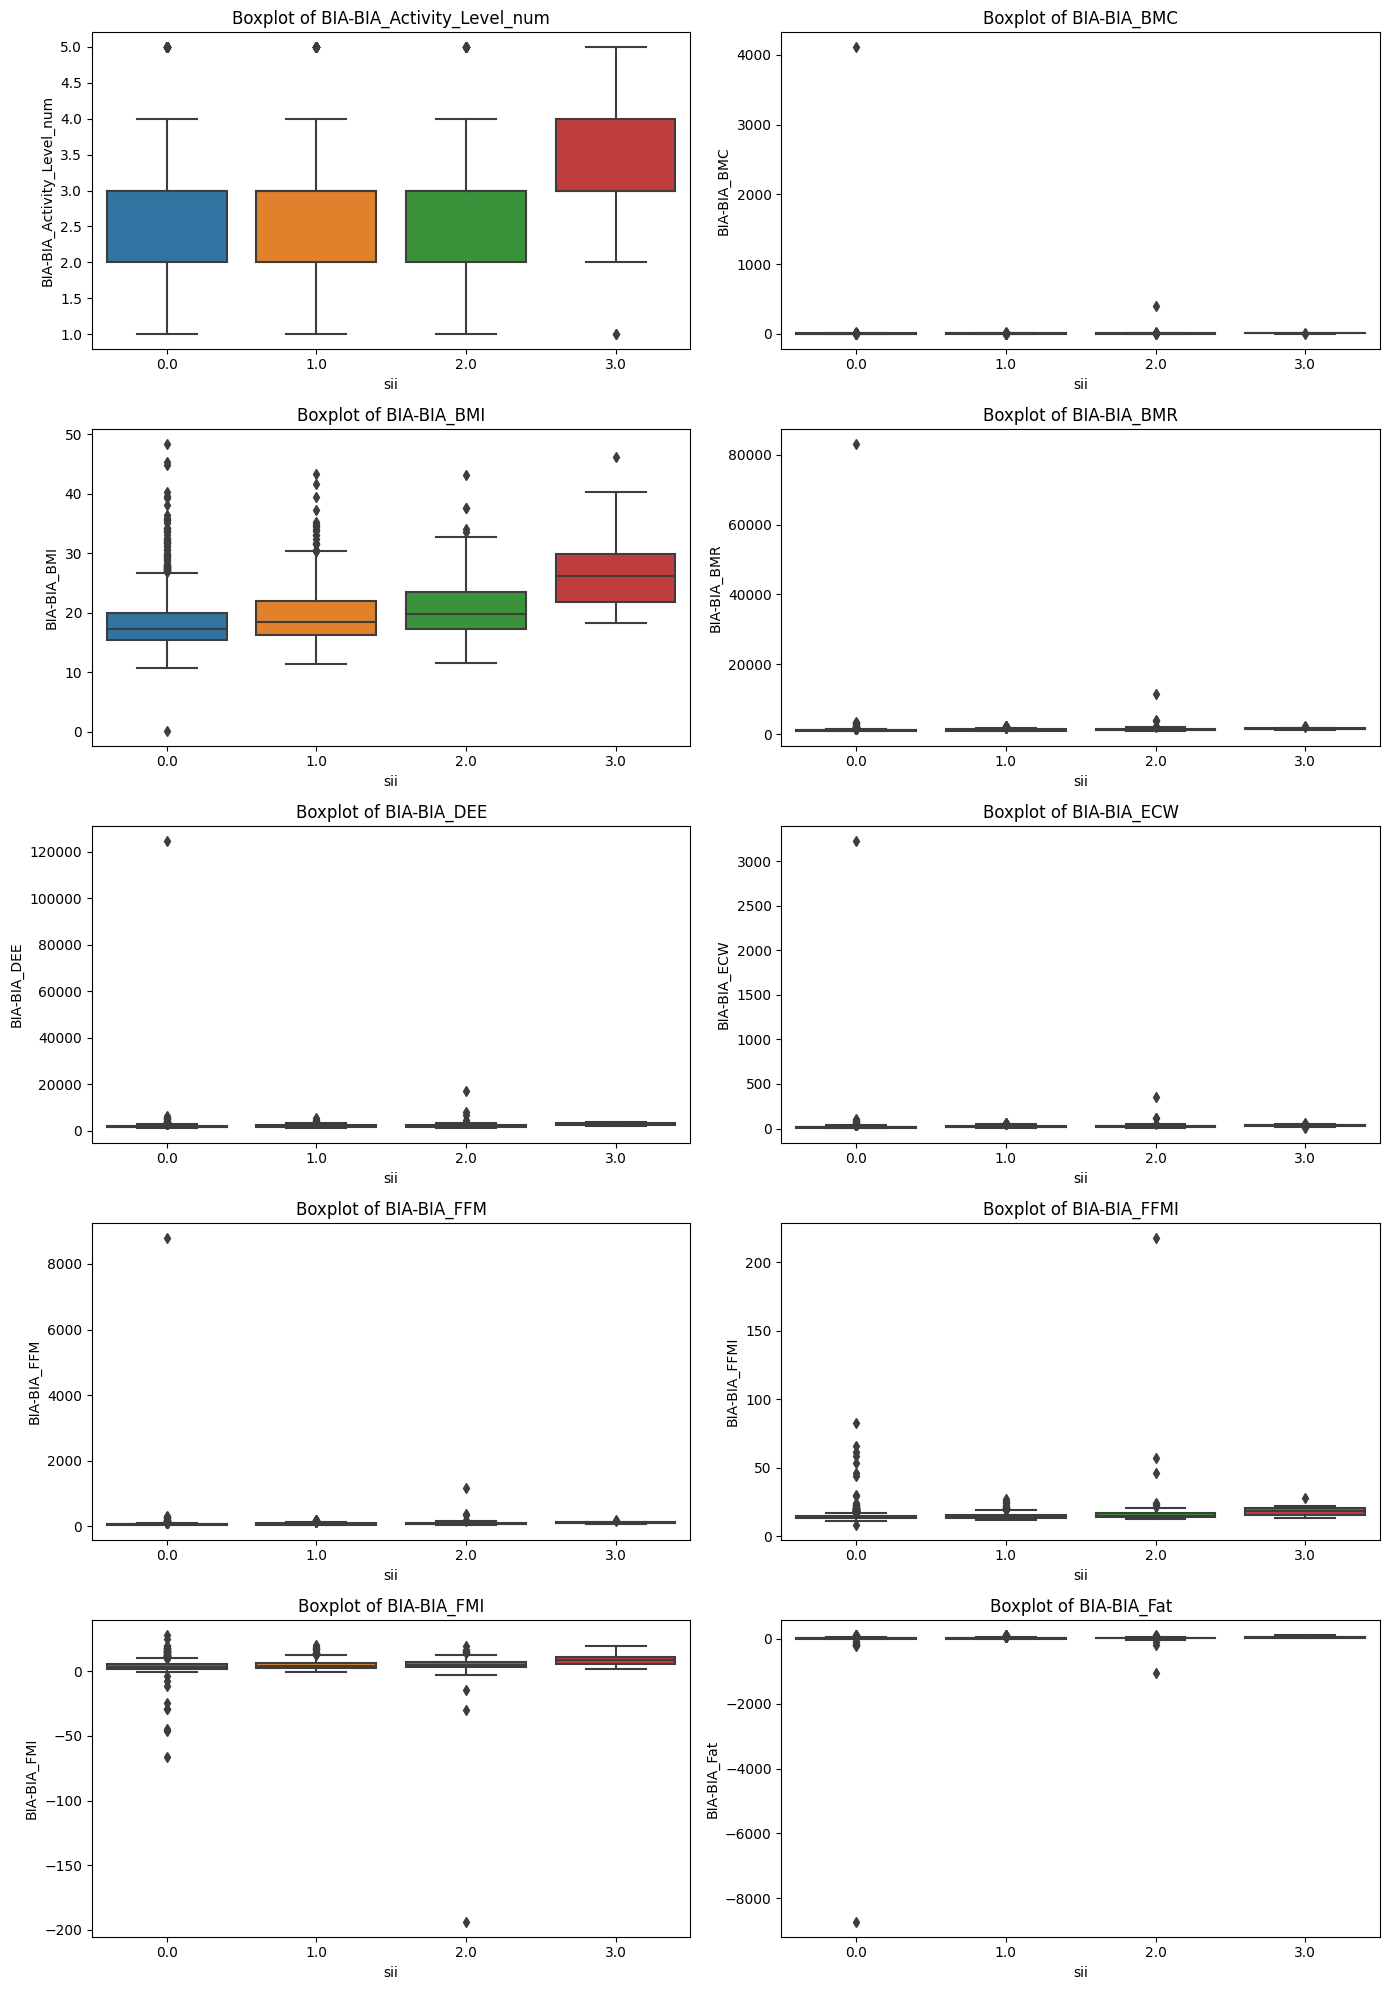

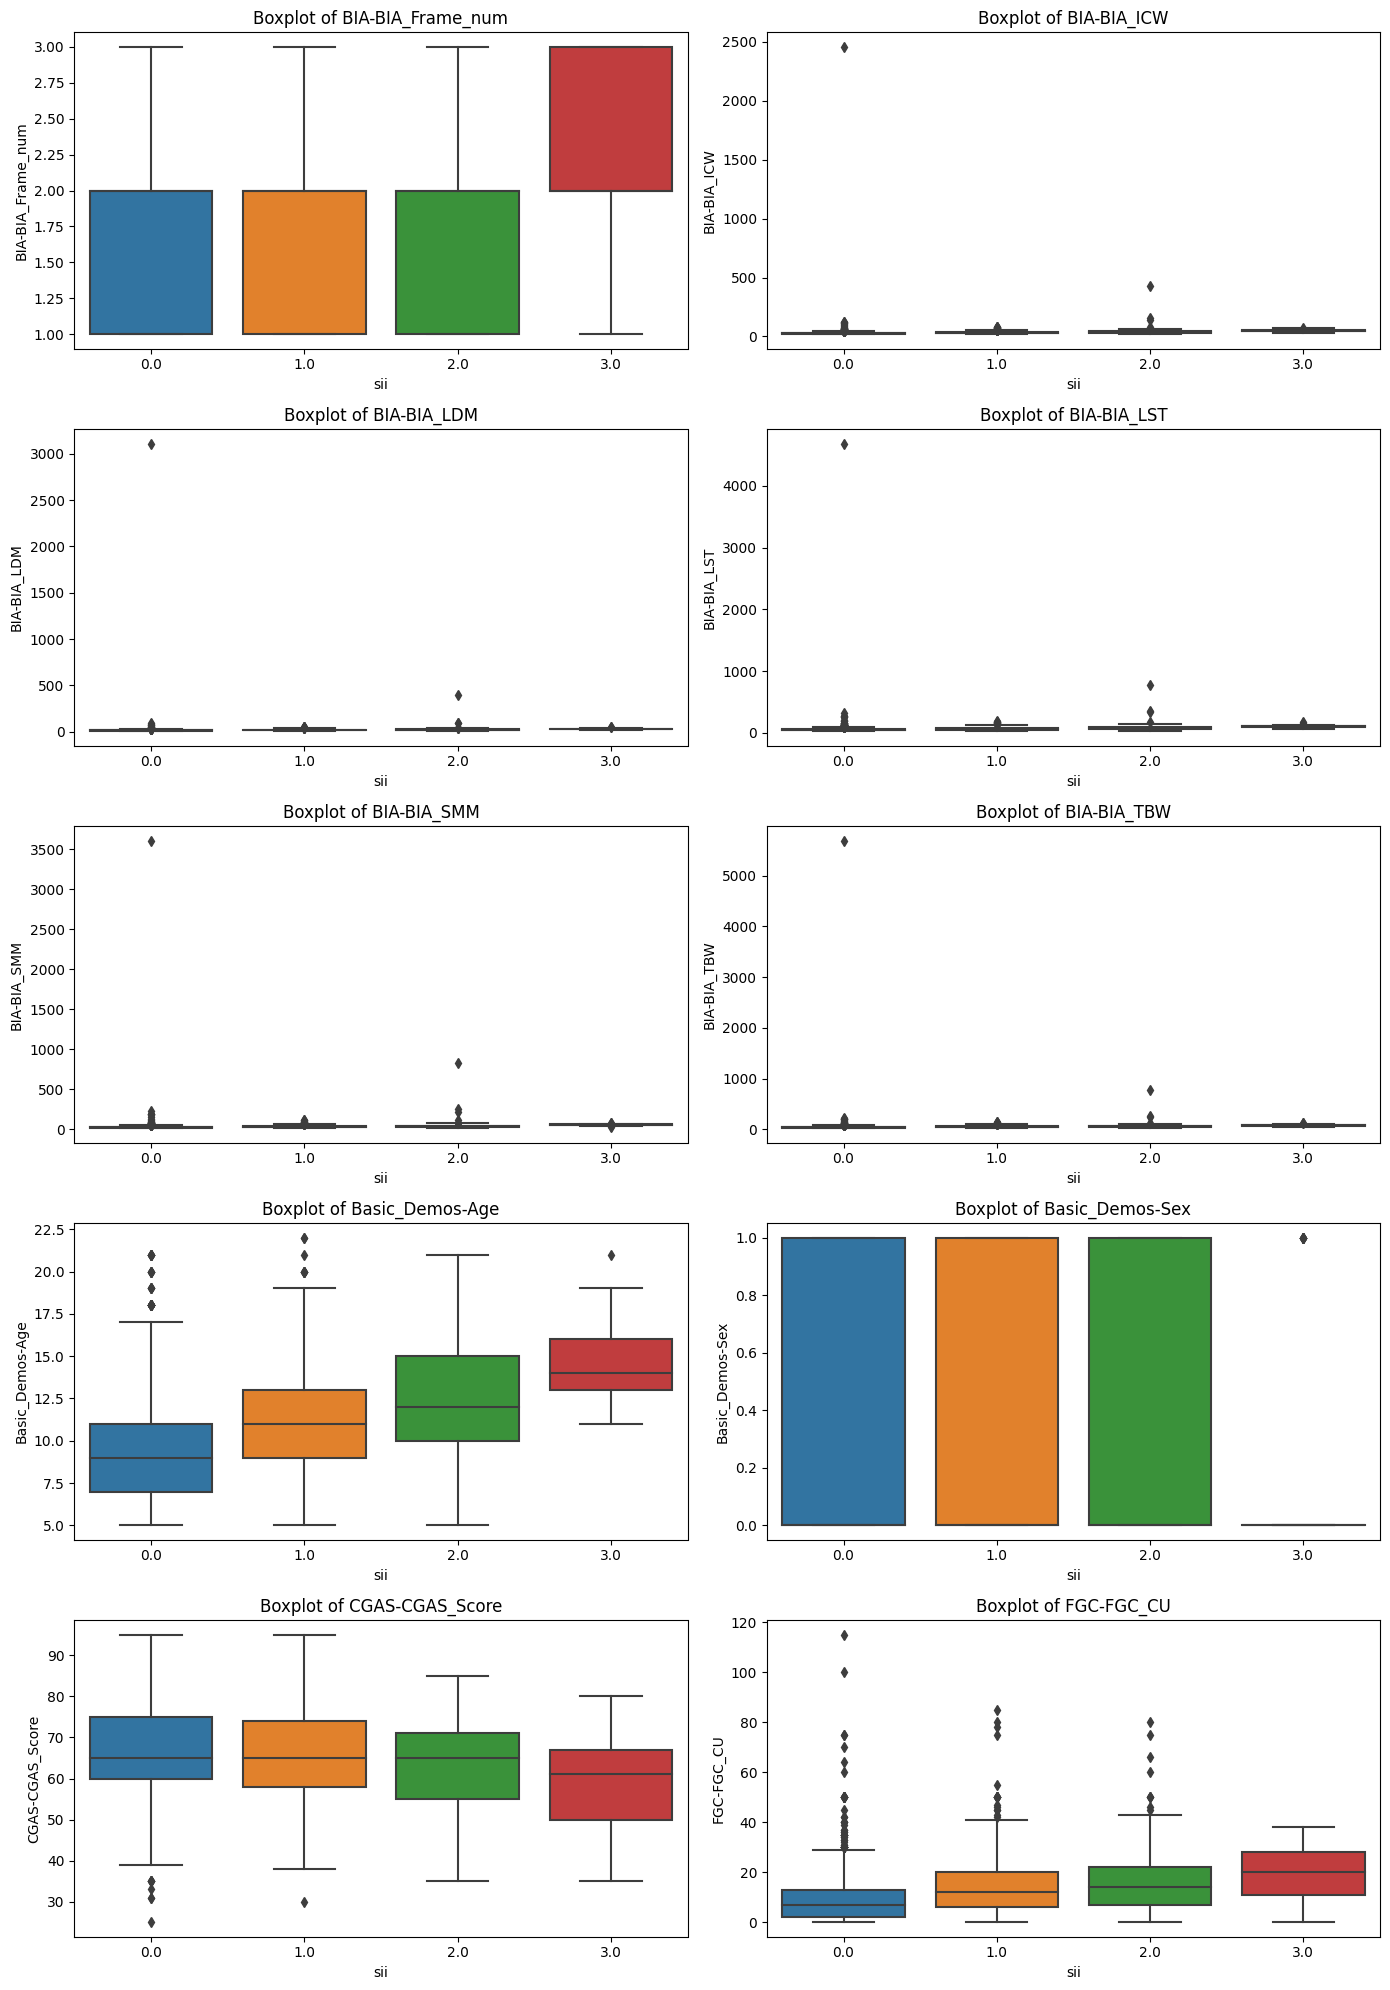

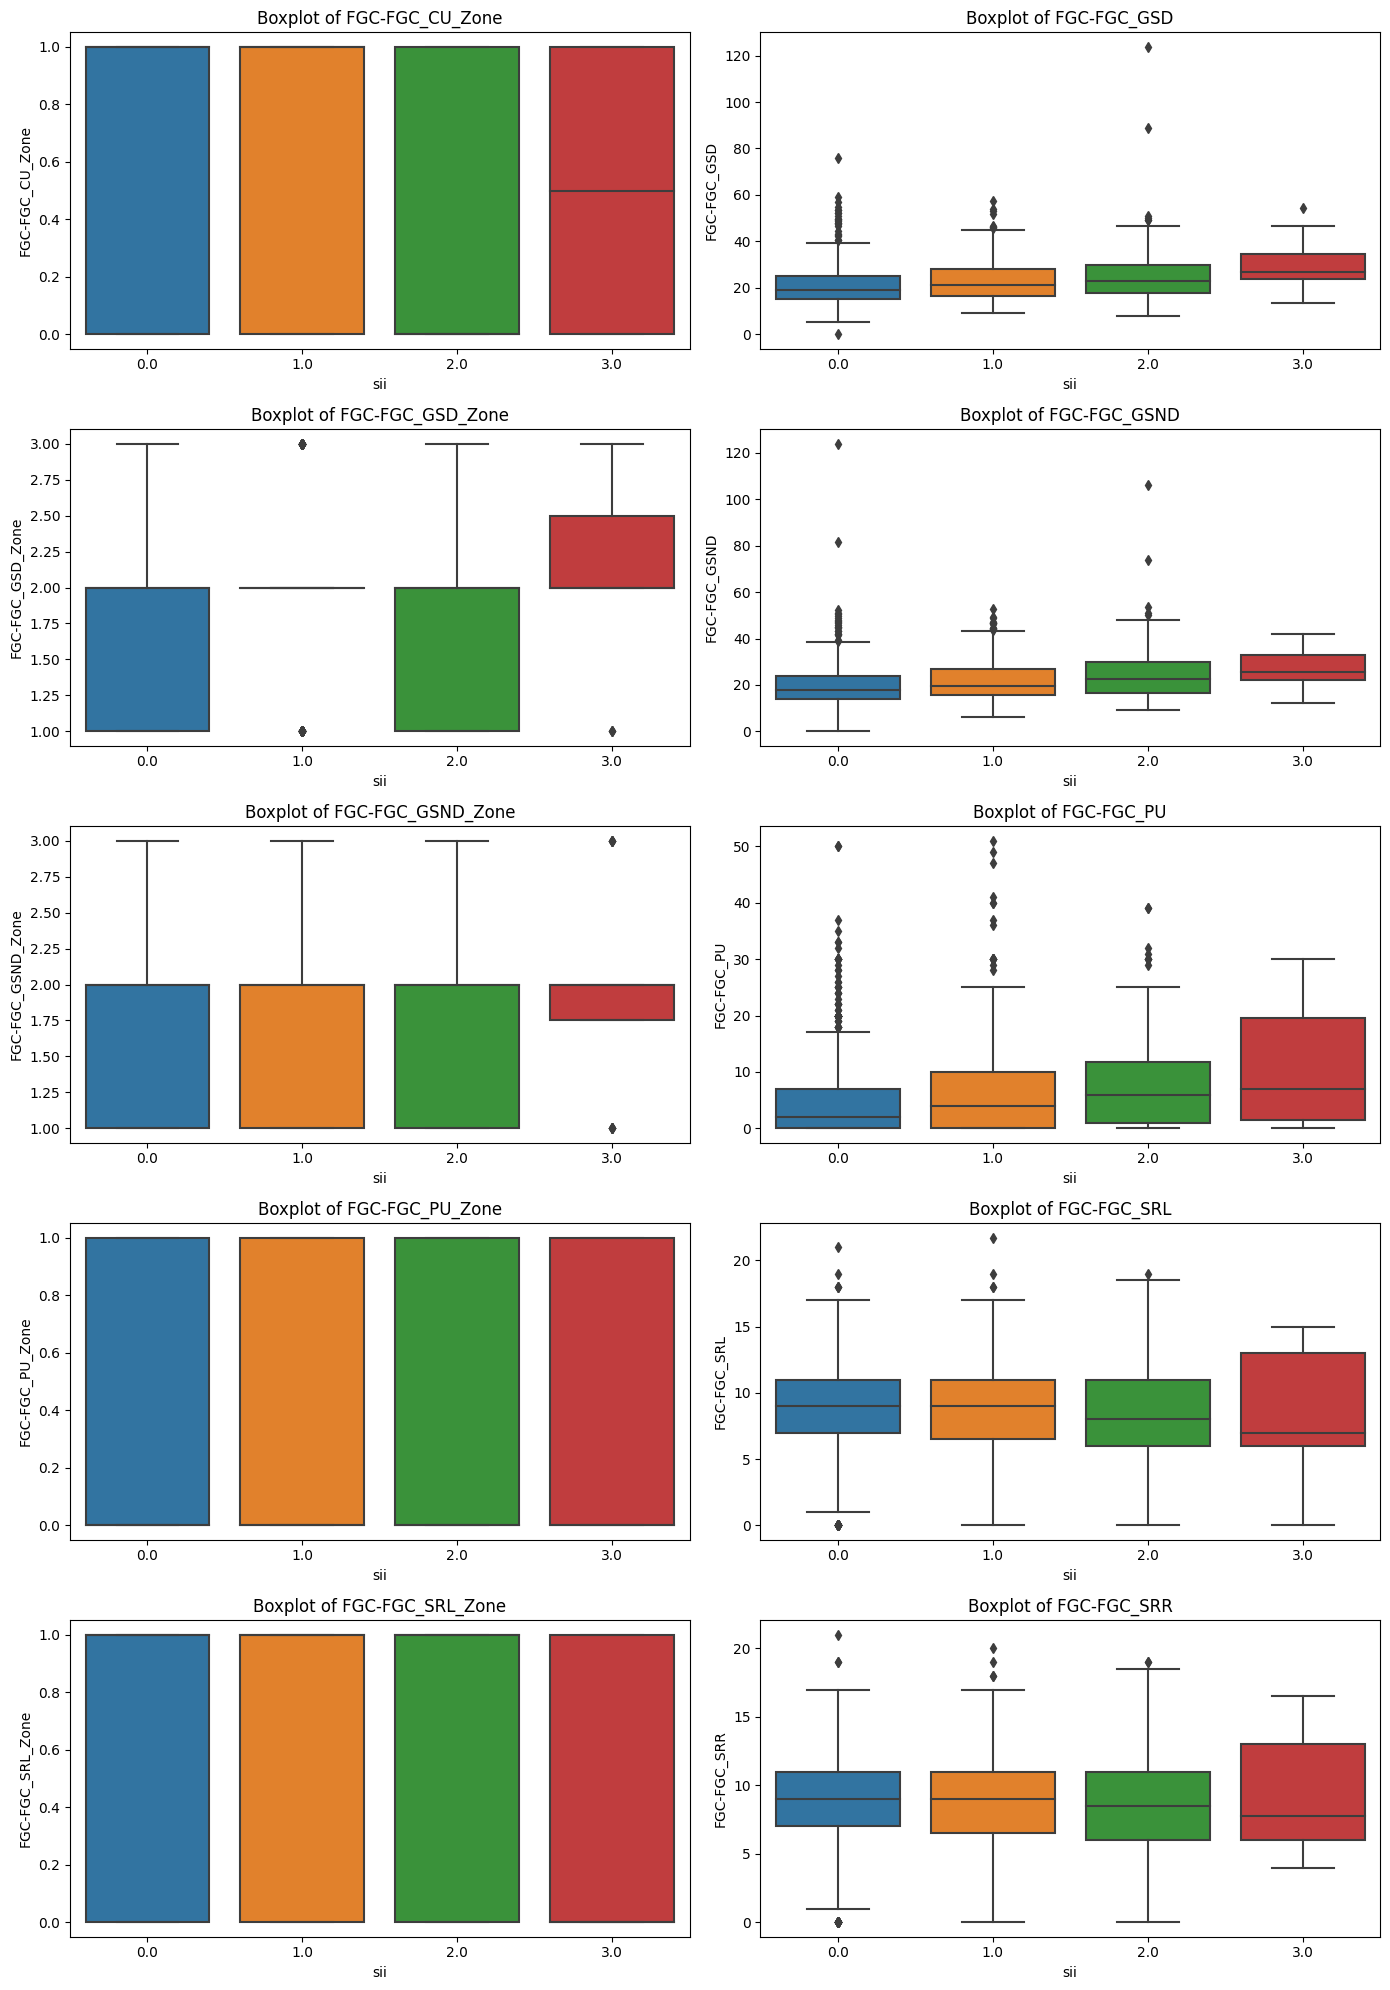

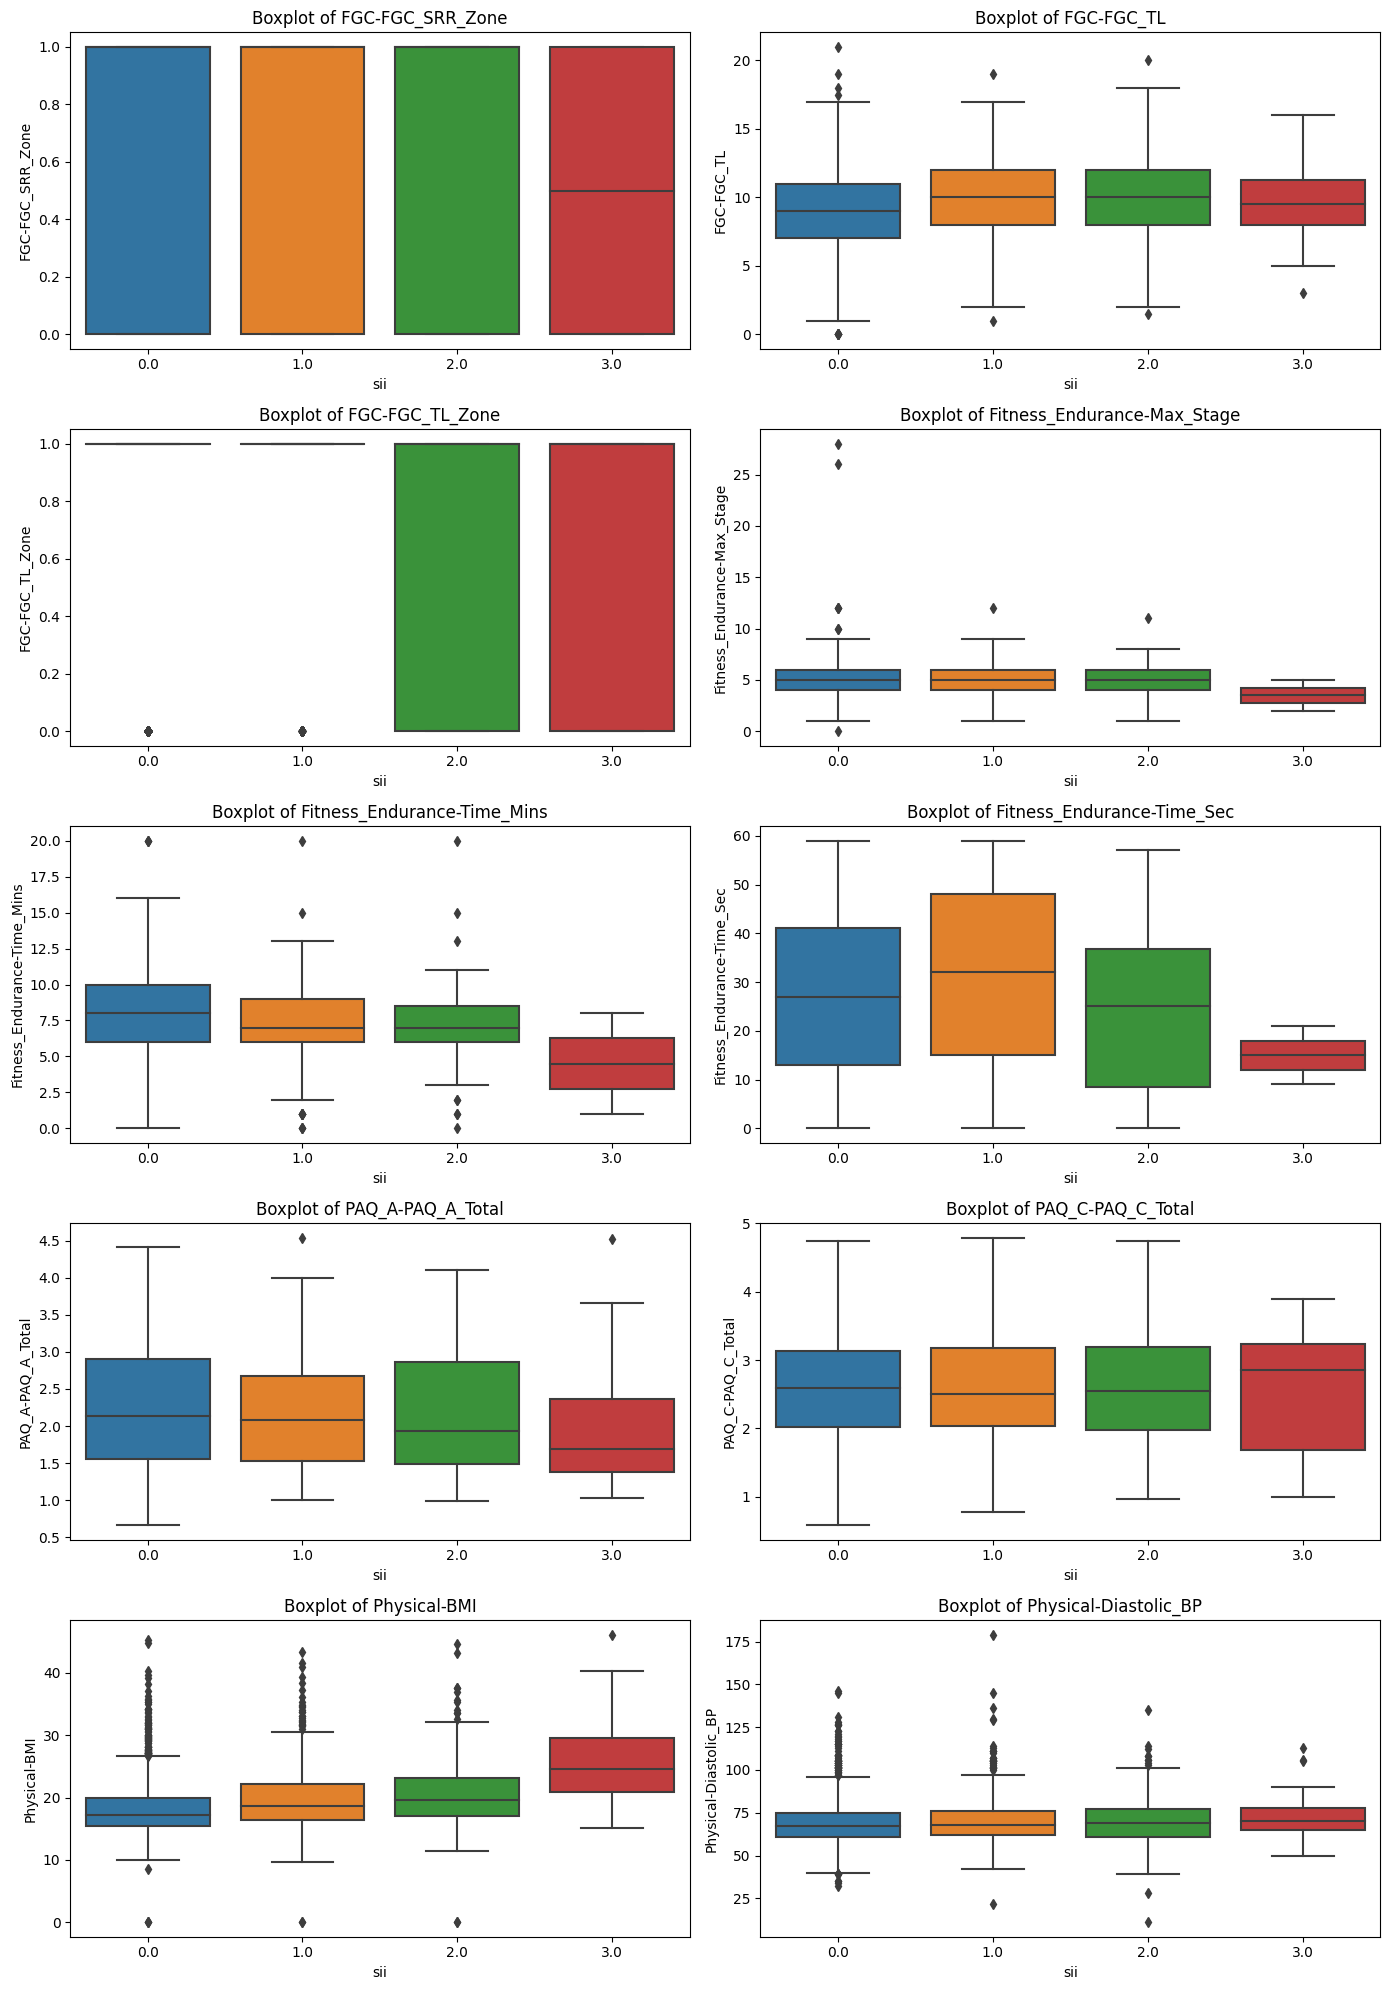

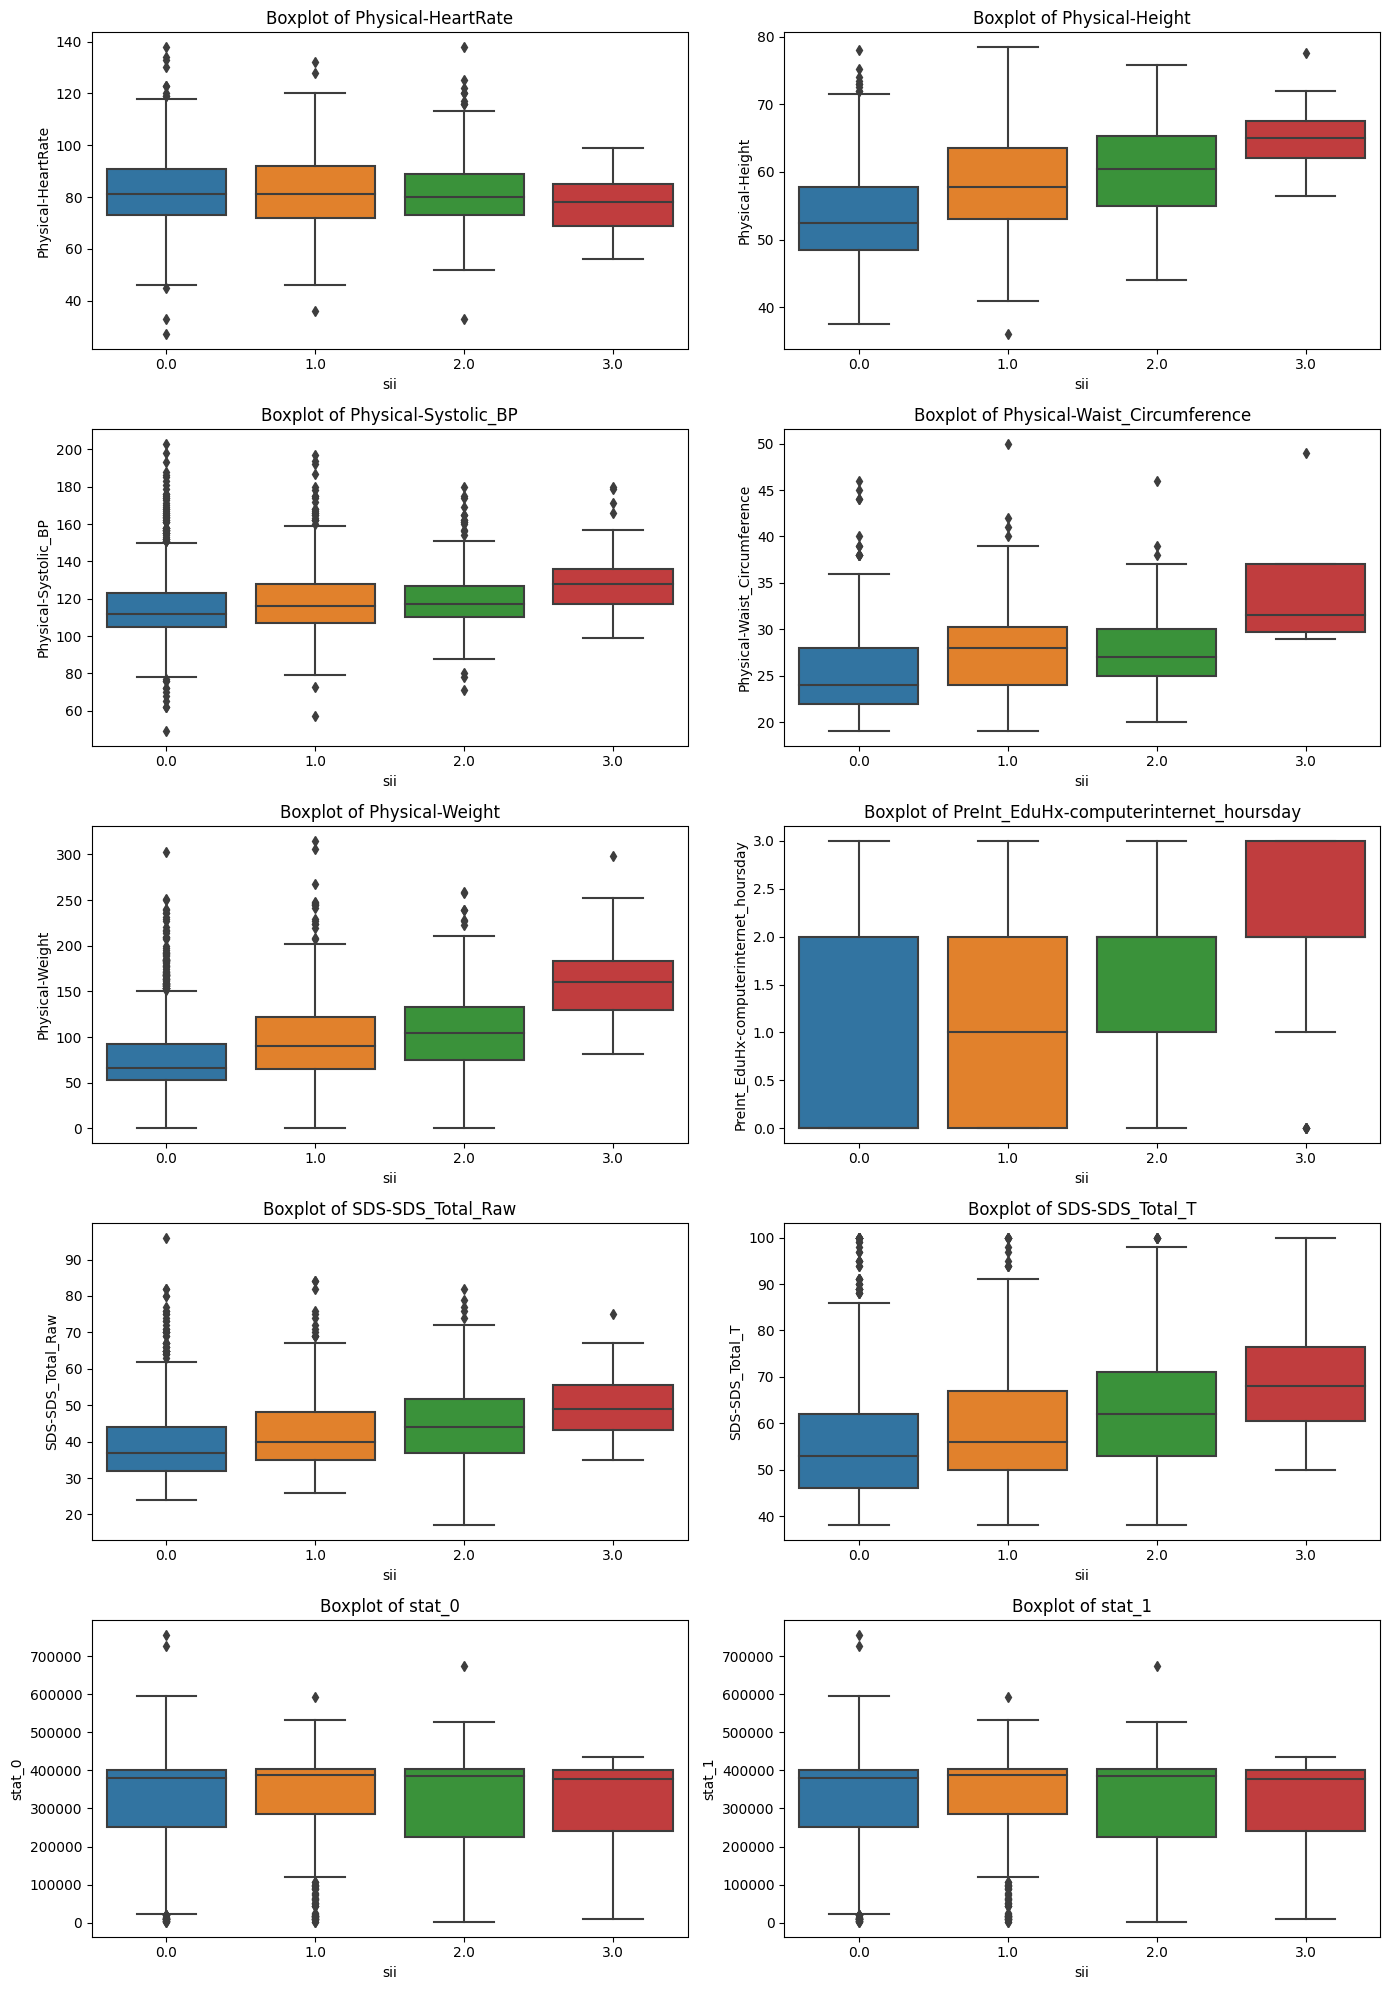

In [32]:
#boxplot of features(of csv)

num = len(numeric_cols) - 96 # 96-->time series features
num_per_batch = 10 
# As the no. of features to plot is too large so, ploting in batchwise to make the plot reada

for i in range(0,num, num_per_batch):
    end = i + num_per_batch
    batch_cols = numeric_cols[i:end]

    plt.figure(figsize = (14, 20))
    for j,col in enumerate(batch_cols,1):
        plt.subplot(5,2,j) # 5X2 subplots per batch
        sns.boxplot(x='sii', y=col, data=train)
        plt.title(f"Boxplot of {col}")
    
    plt.tight_layout()
    plt.show()

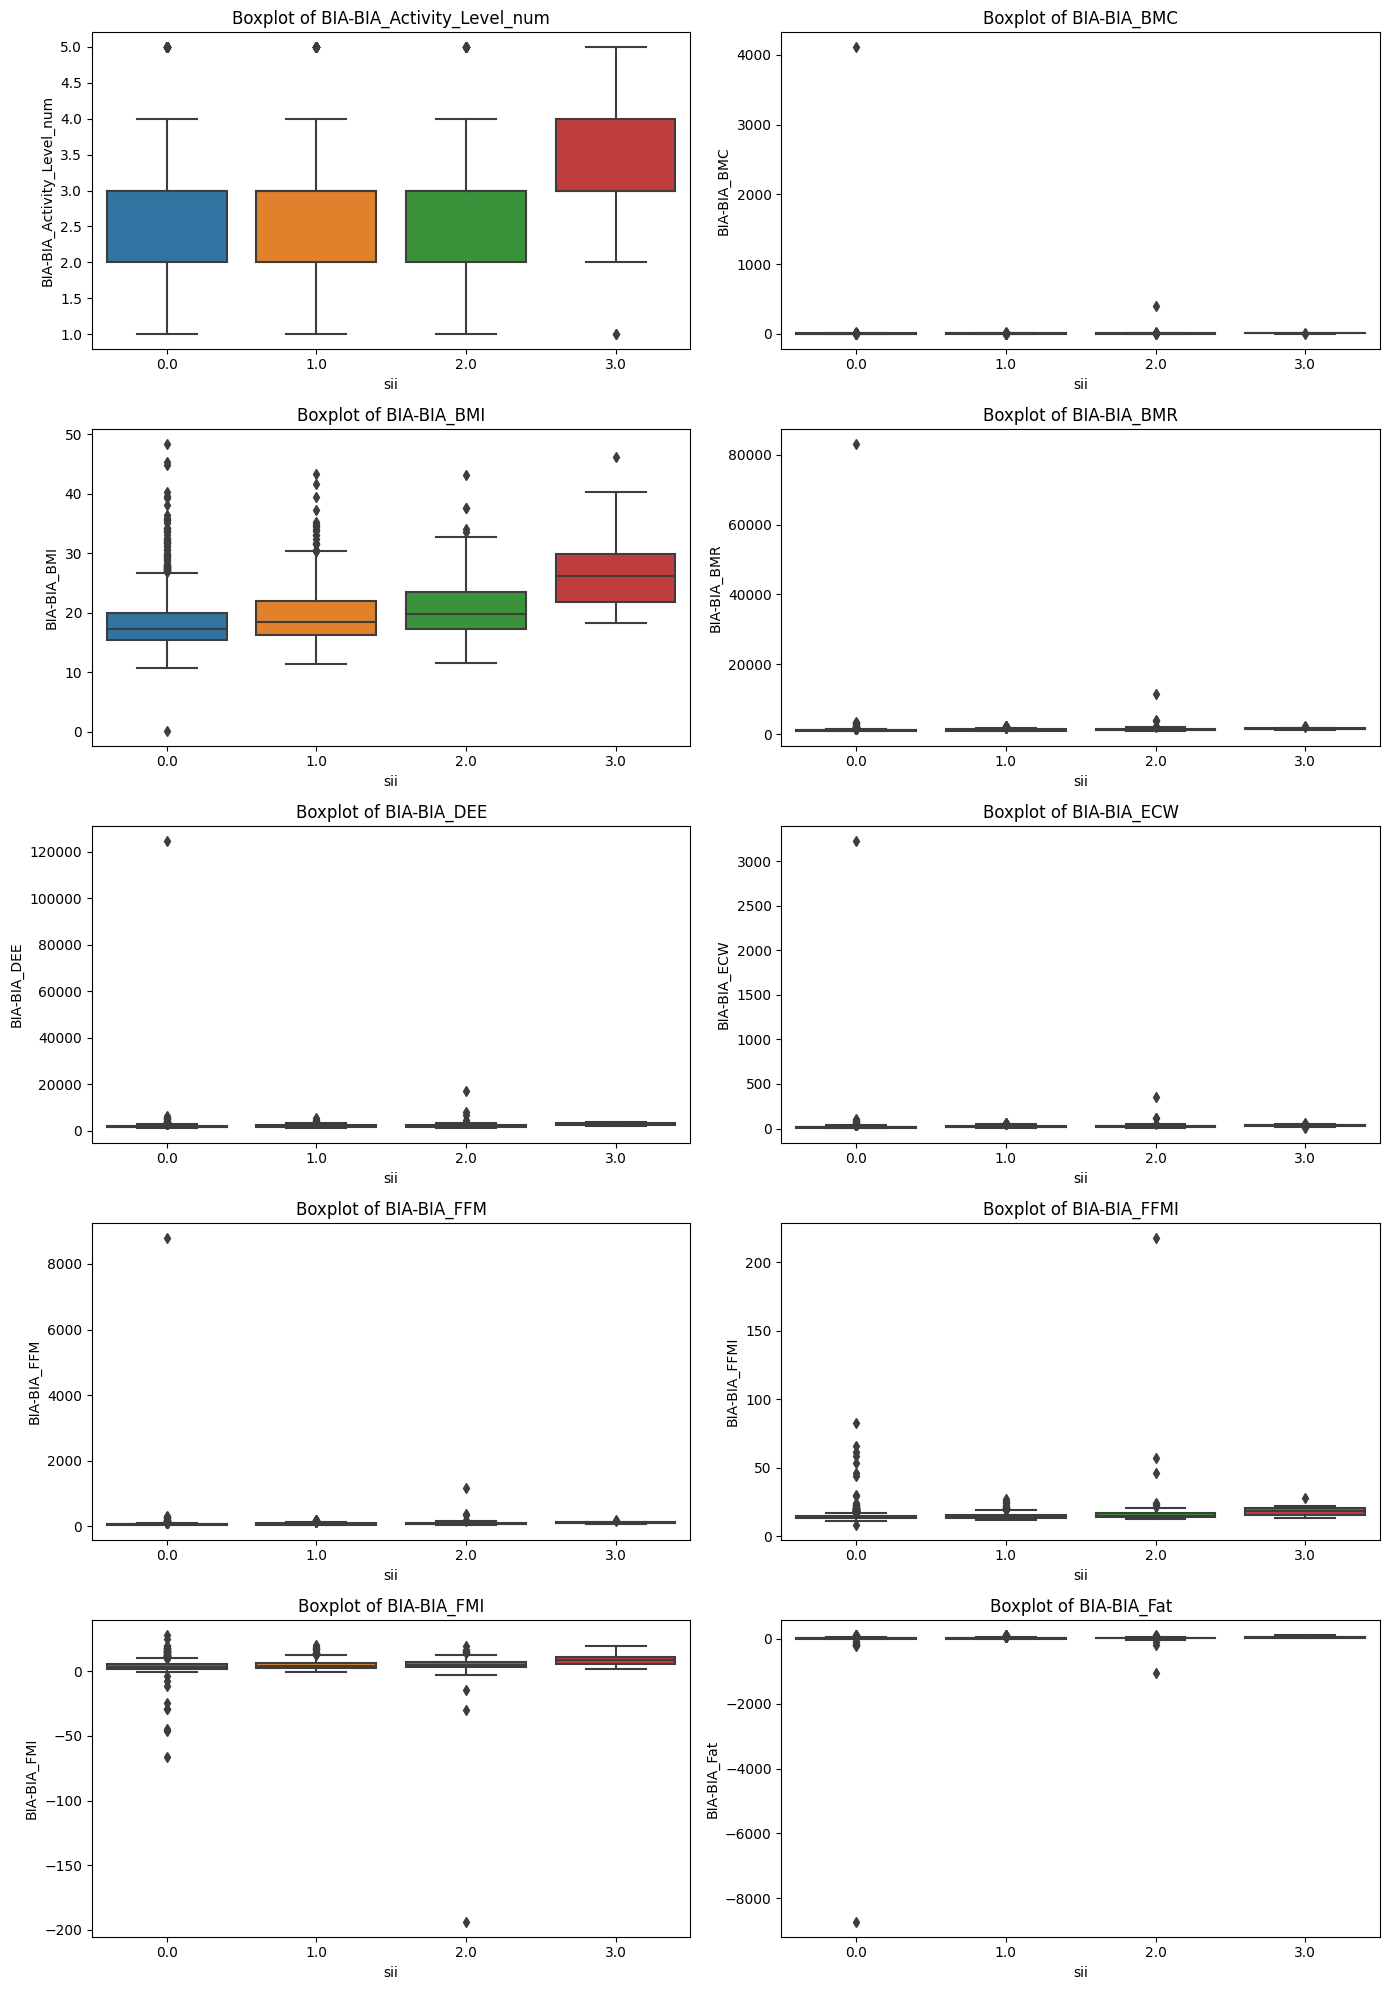

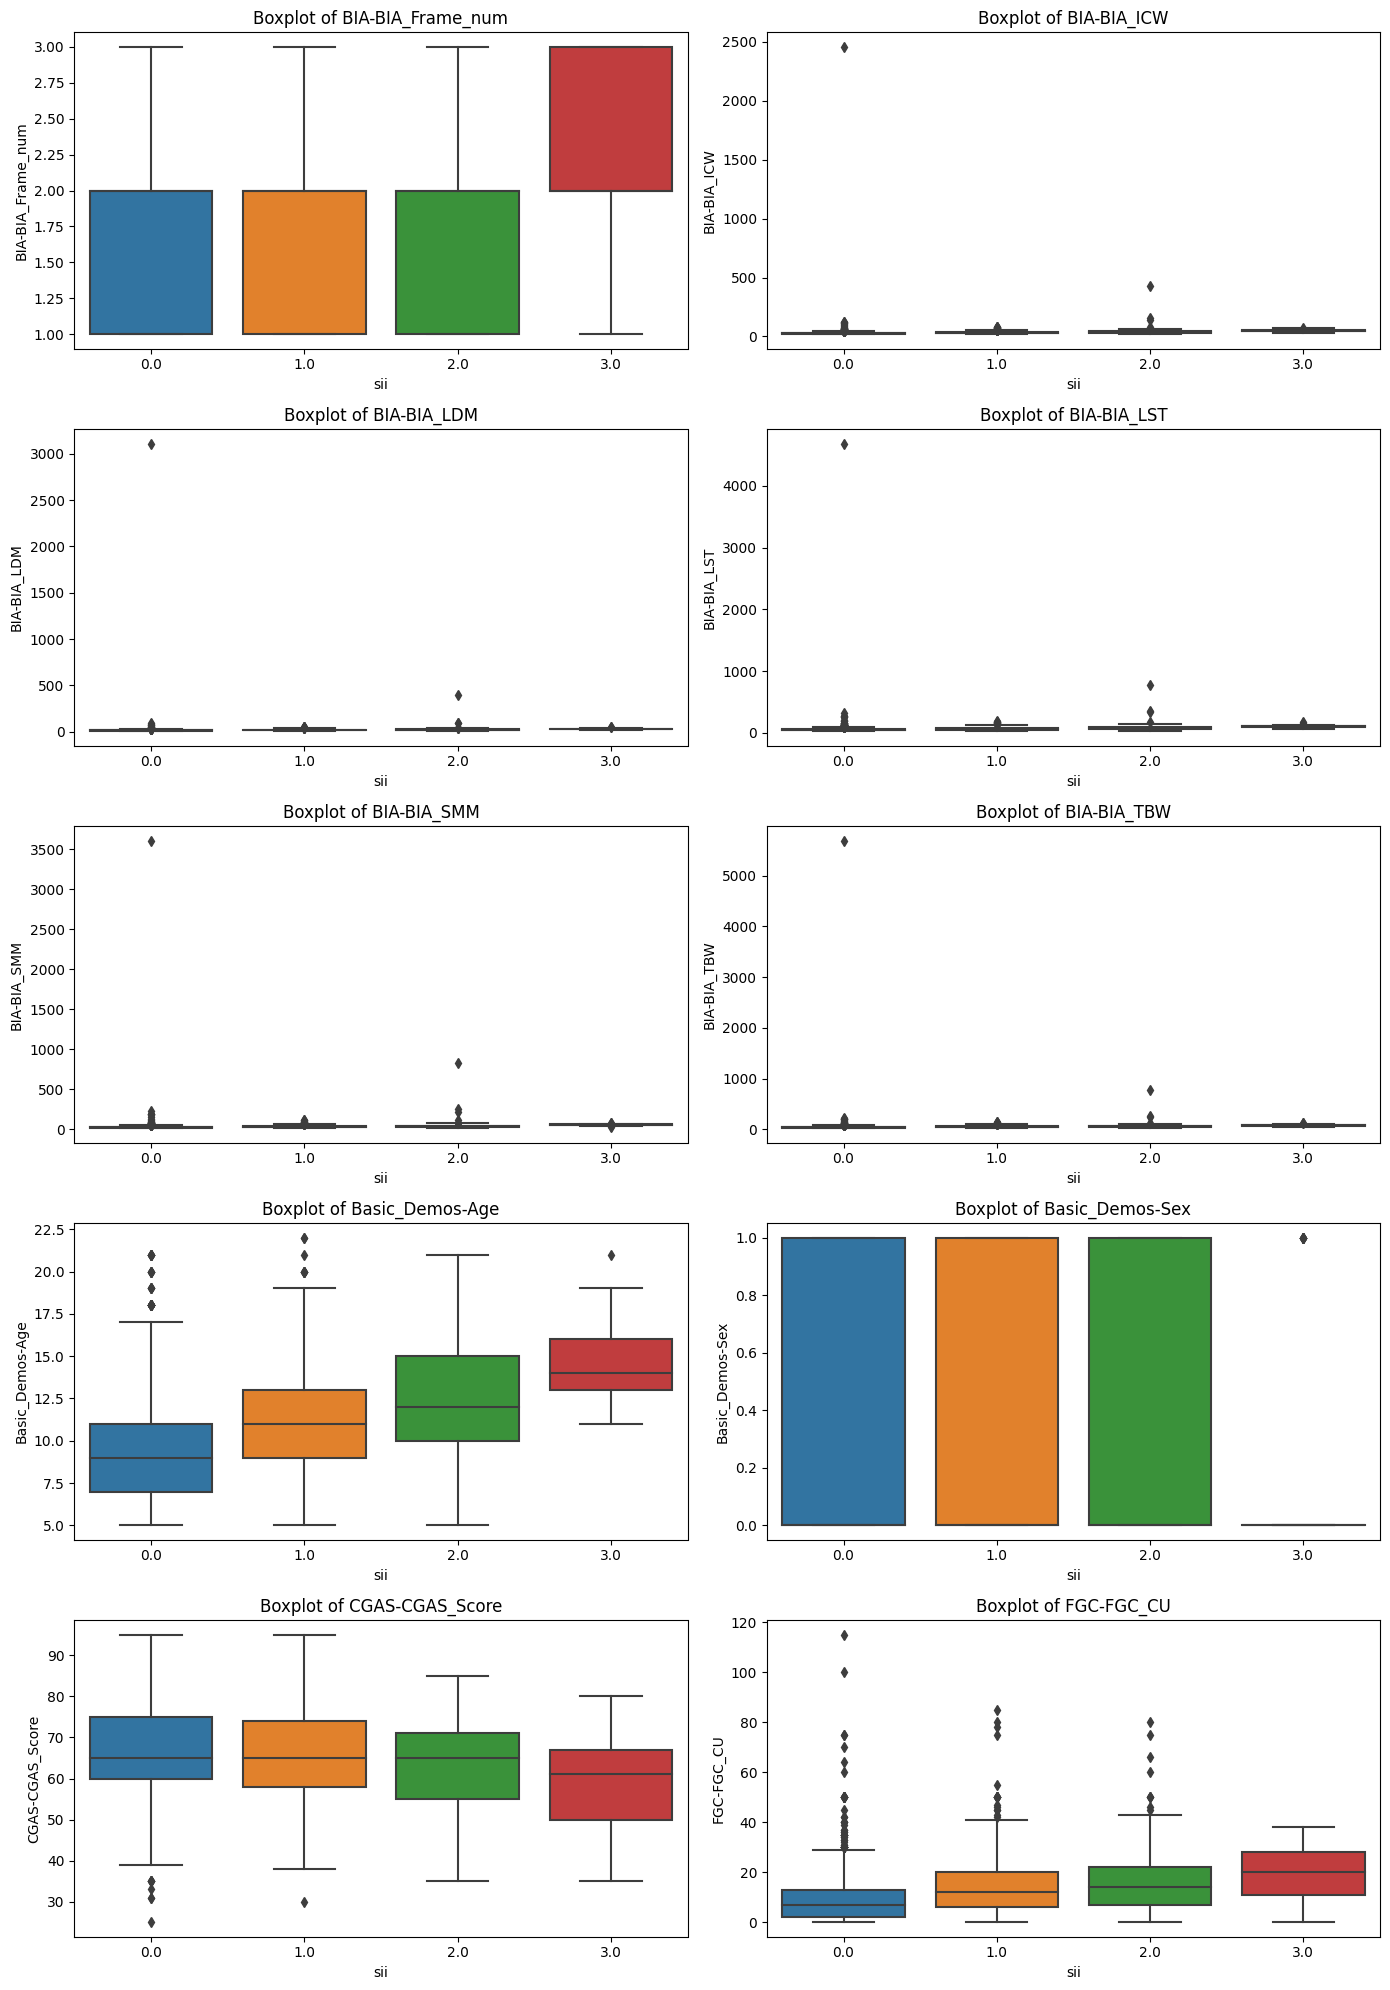

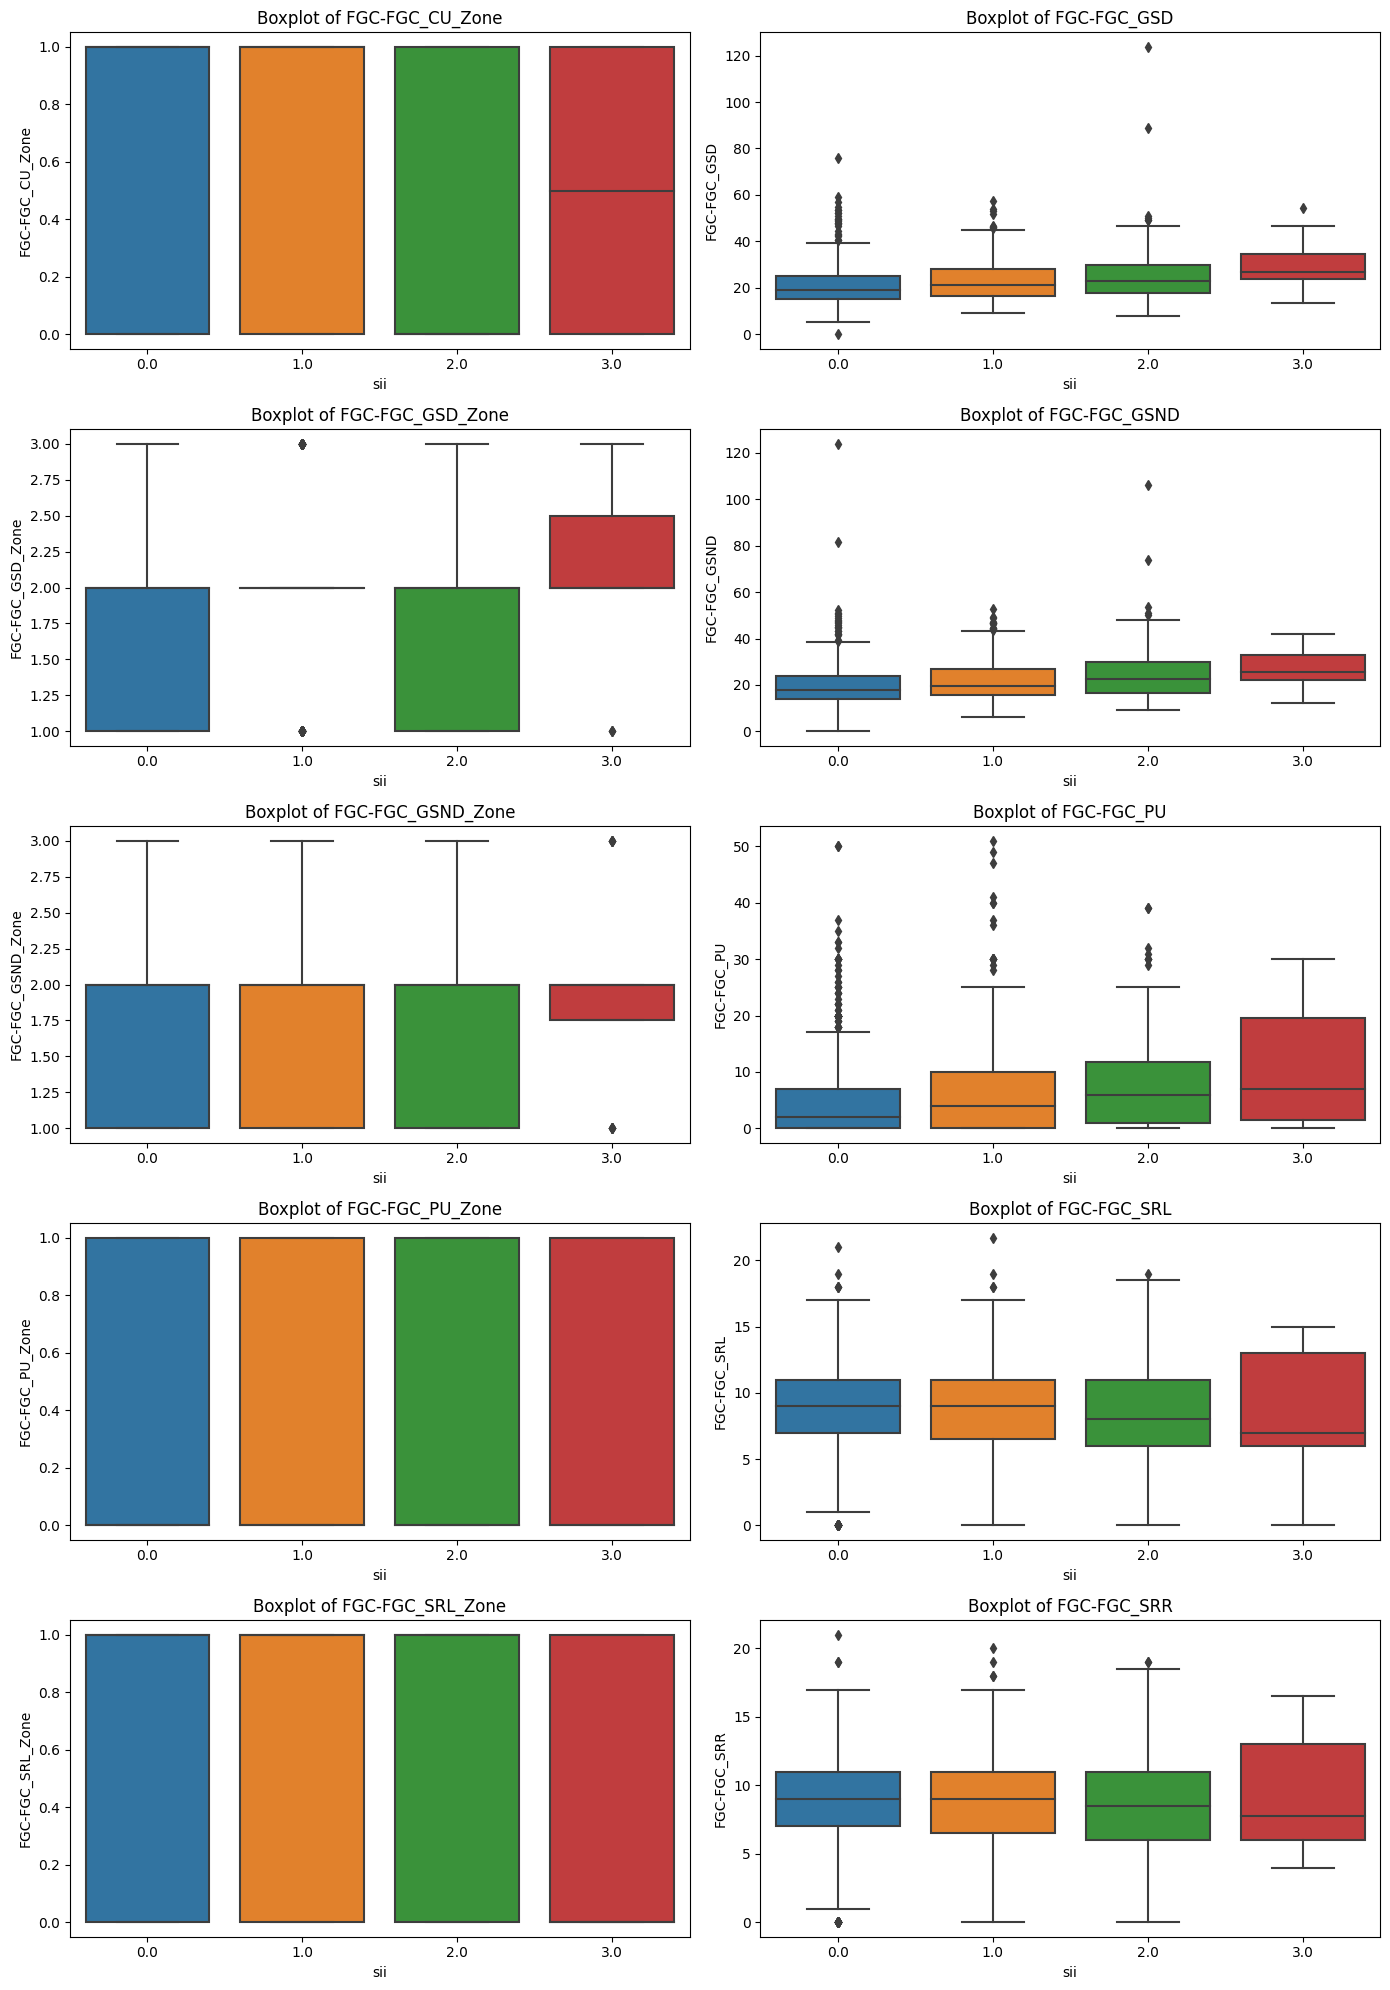

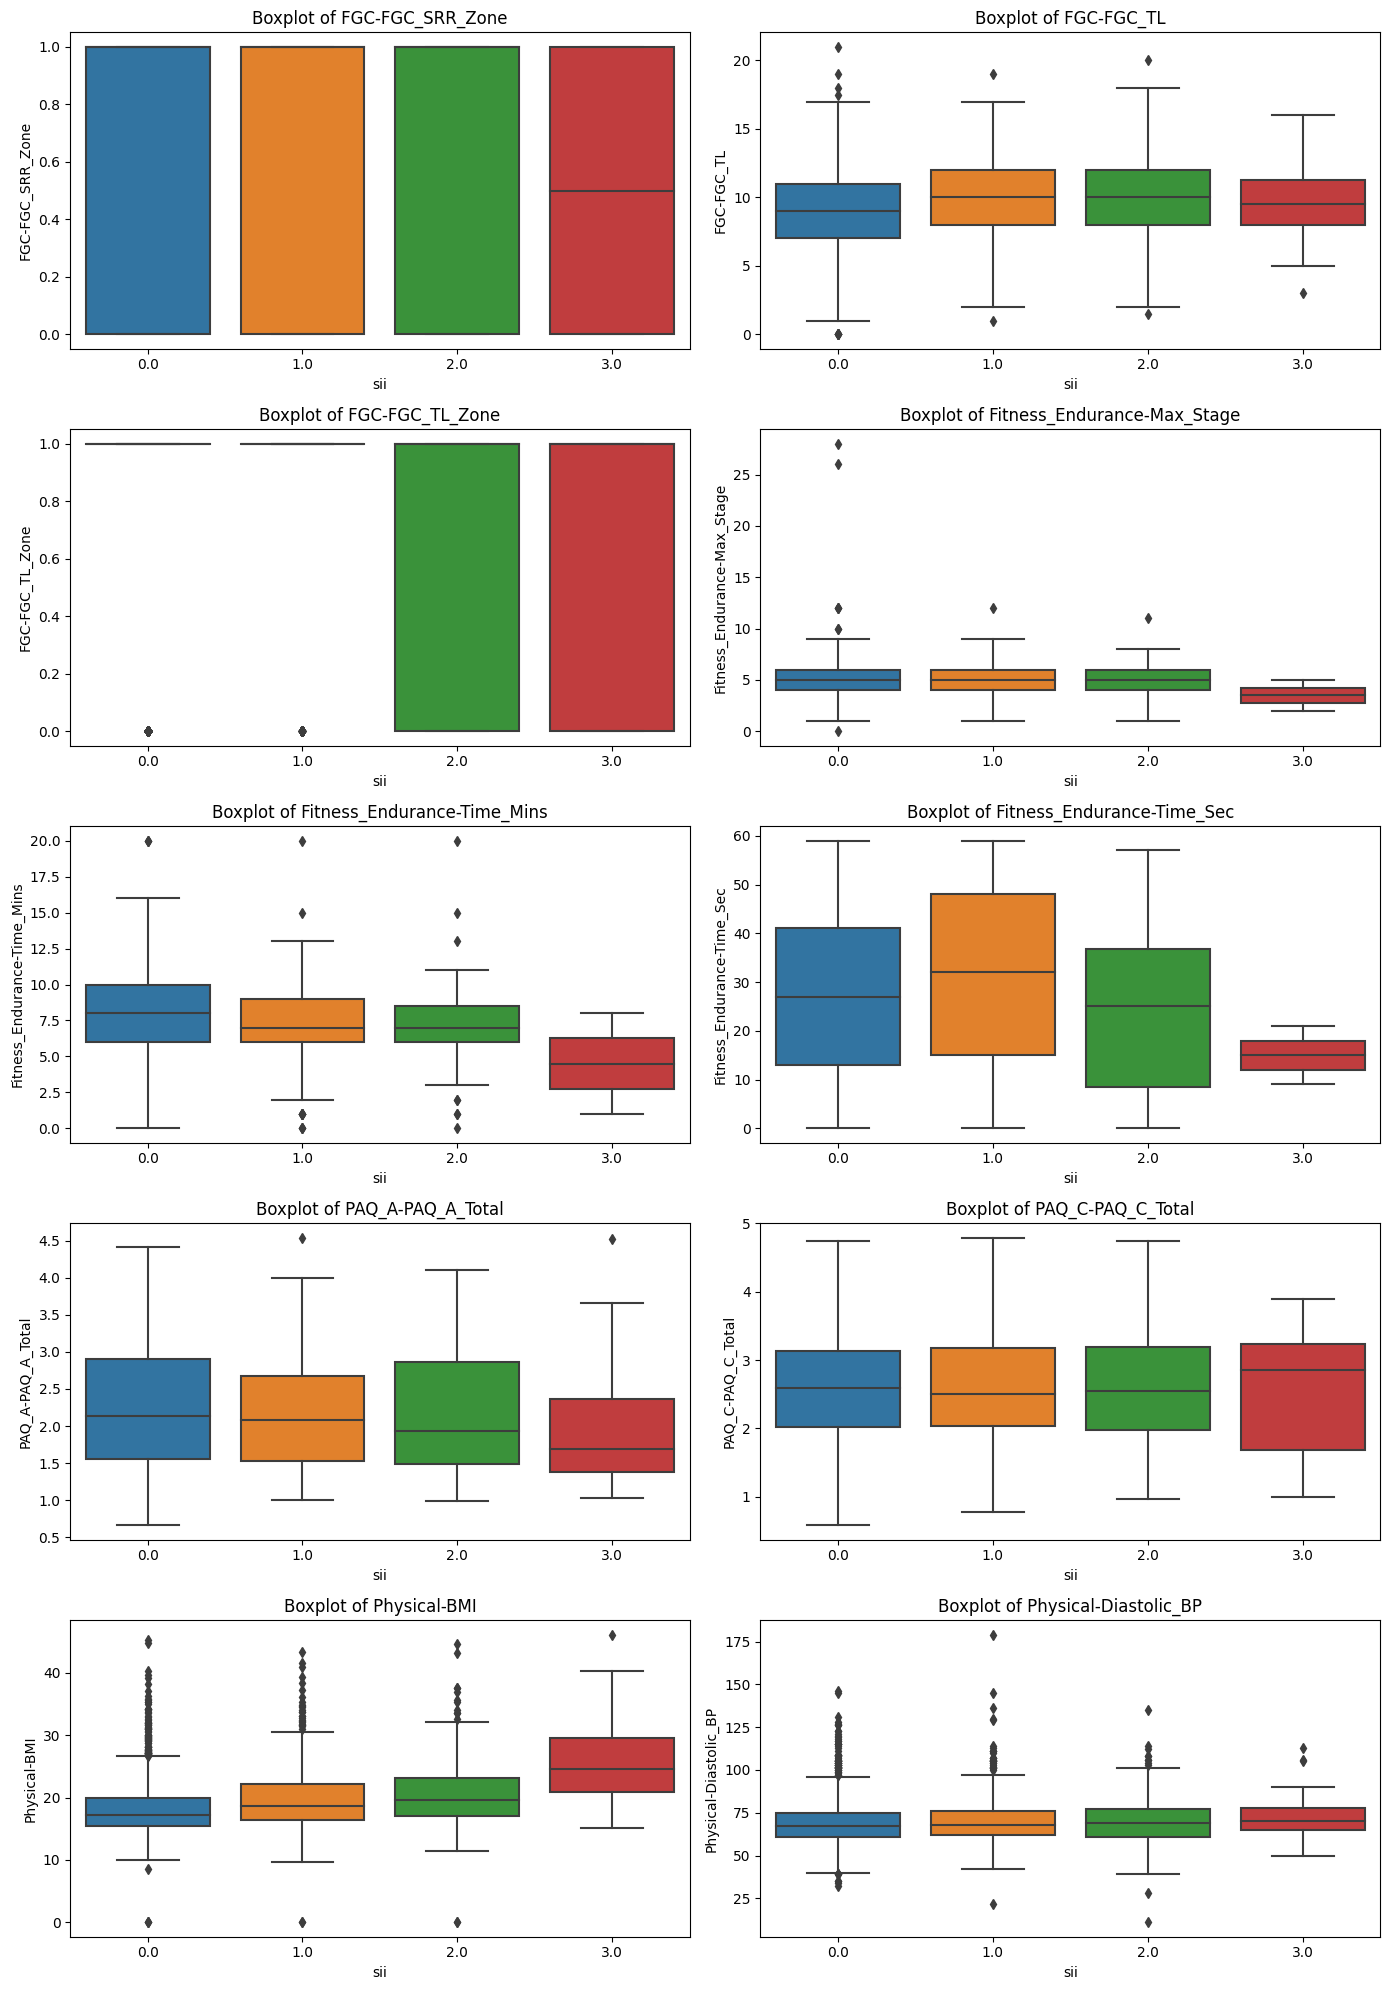

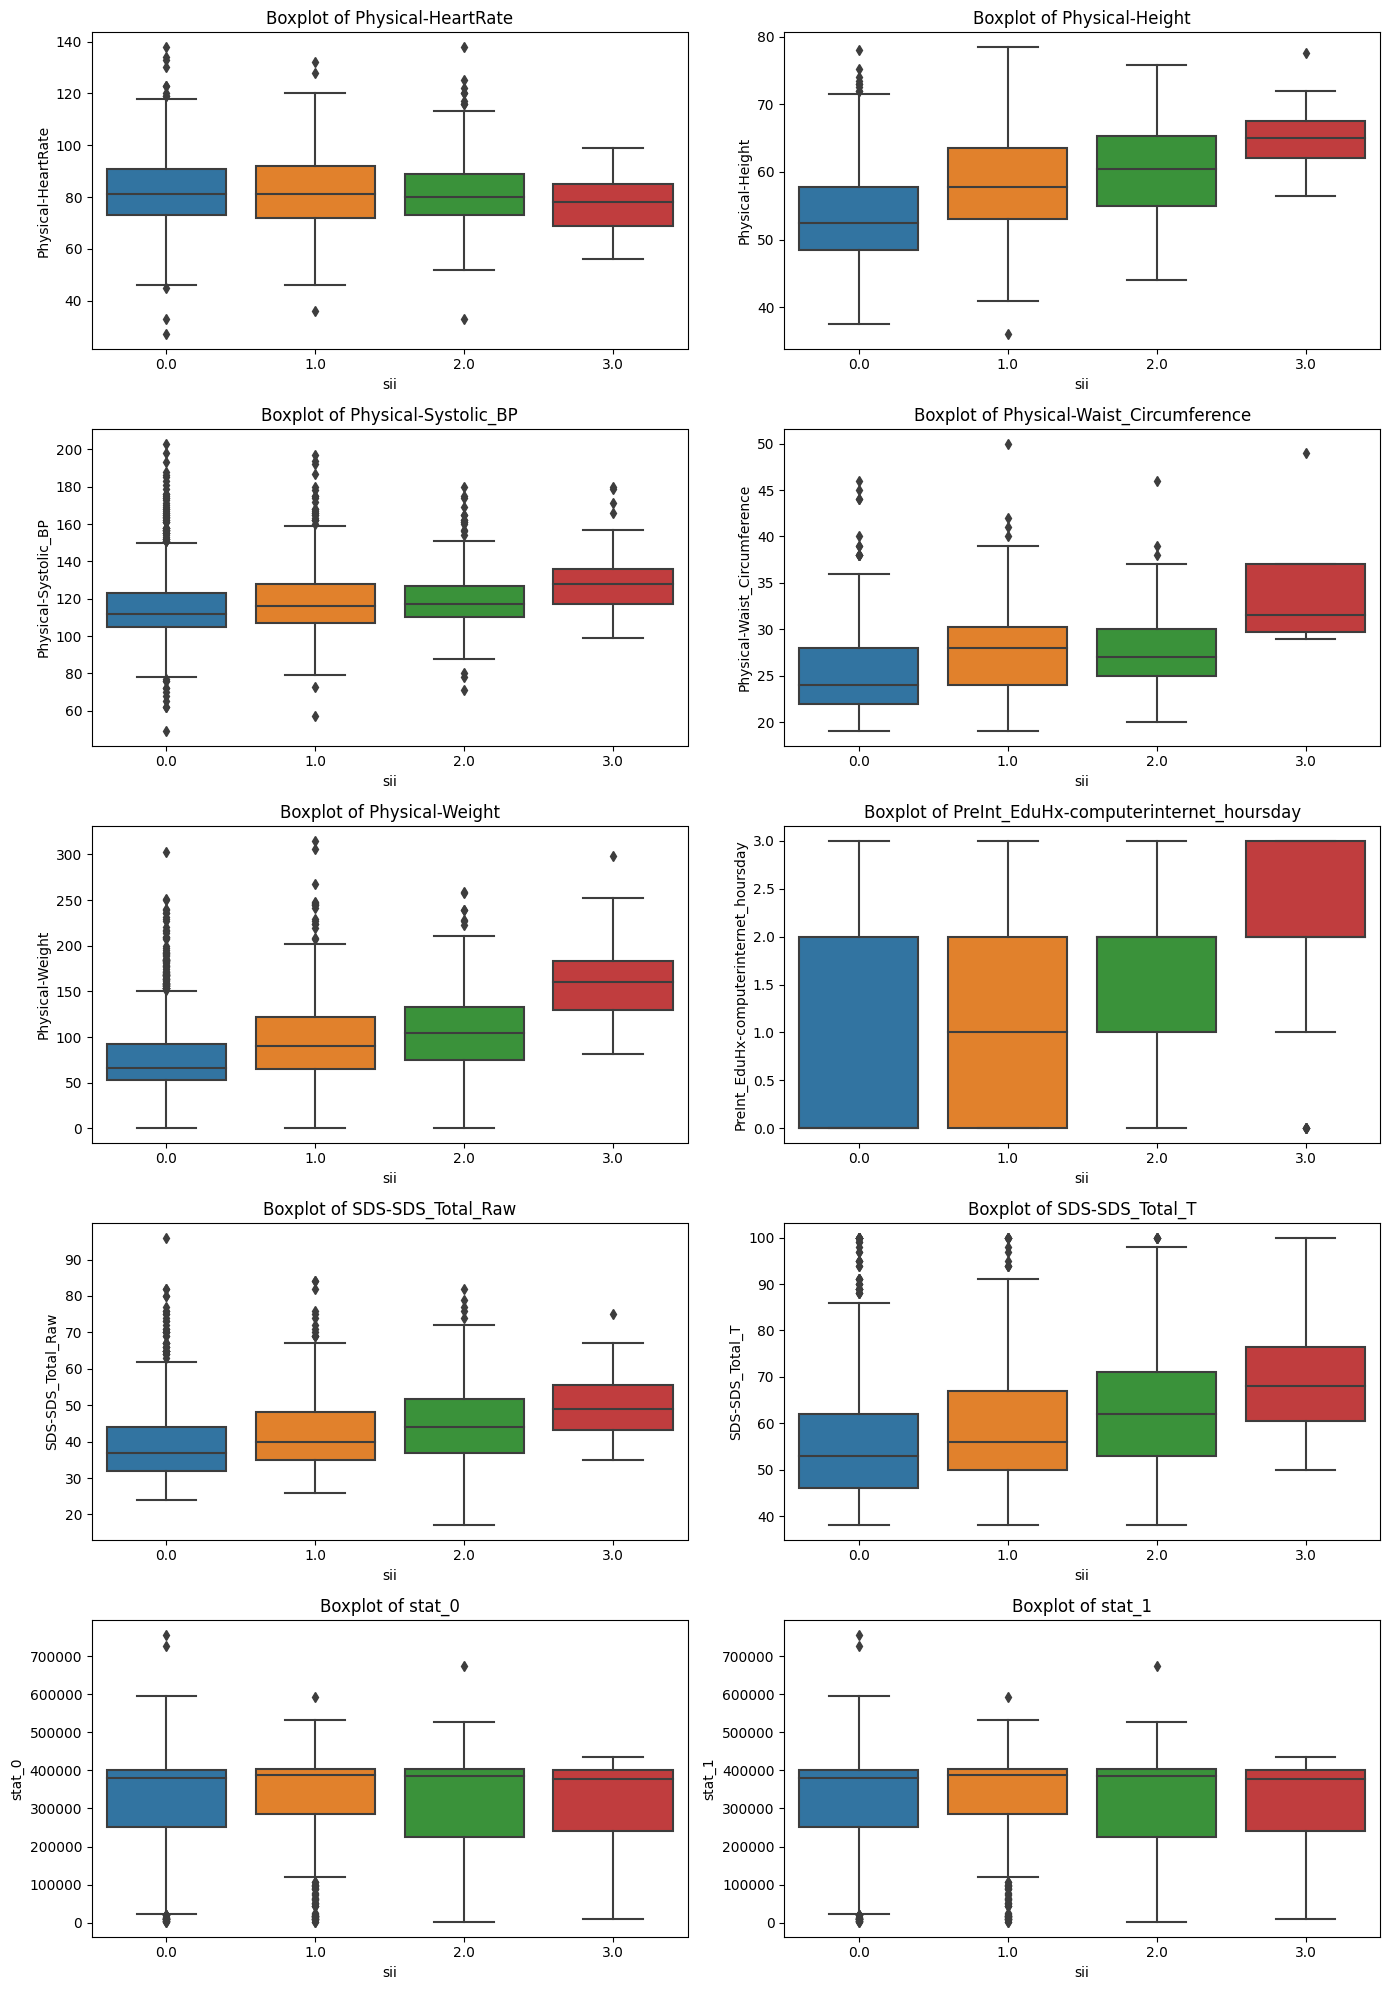

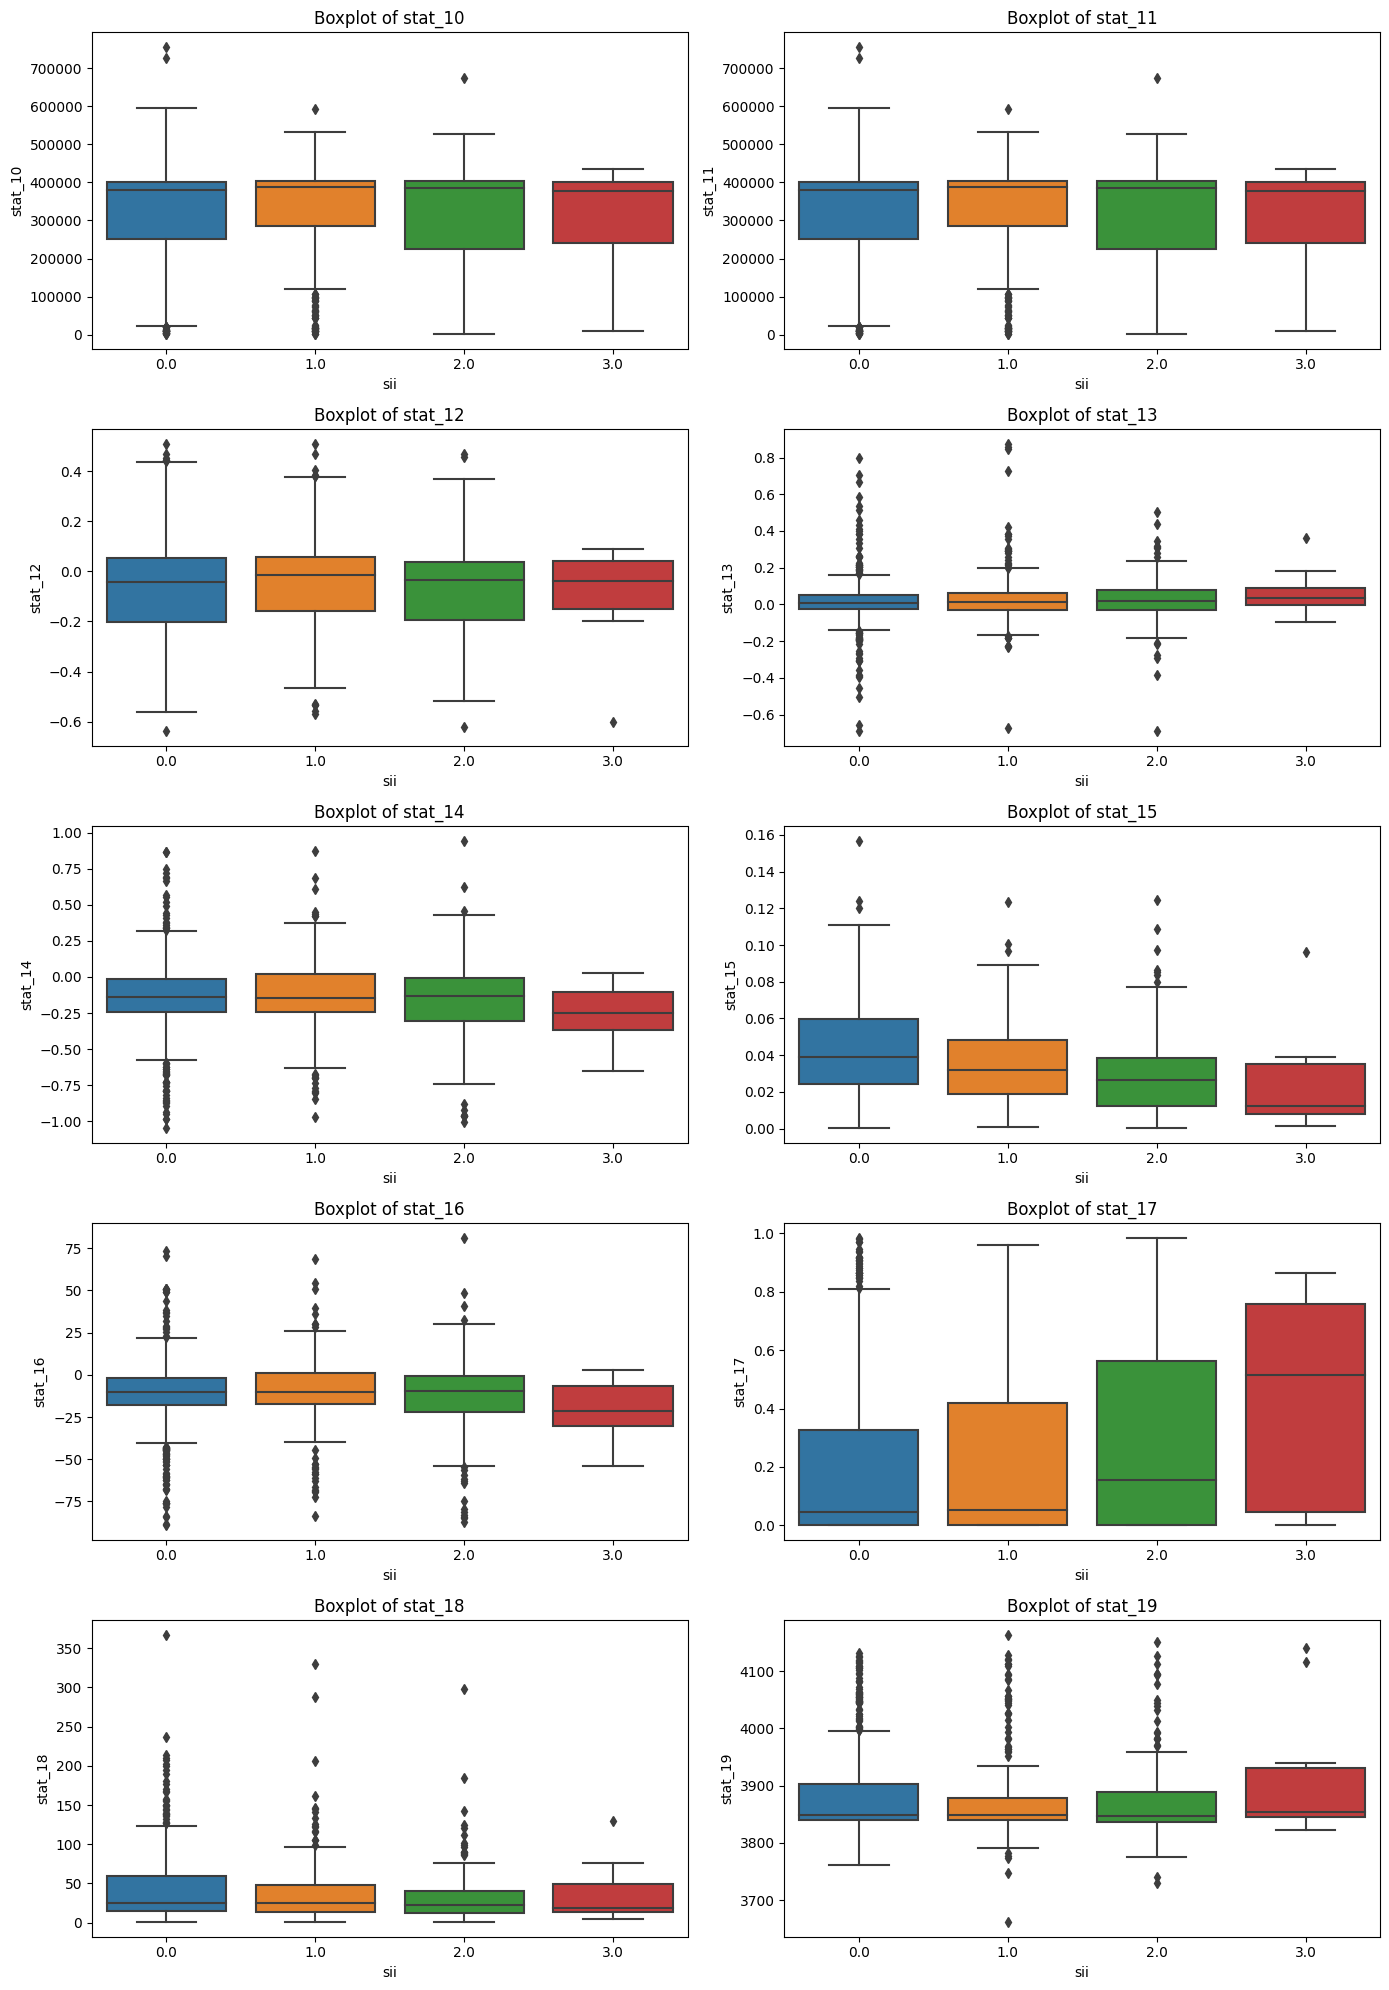

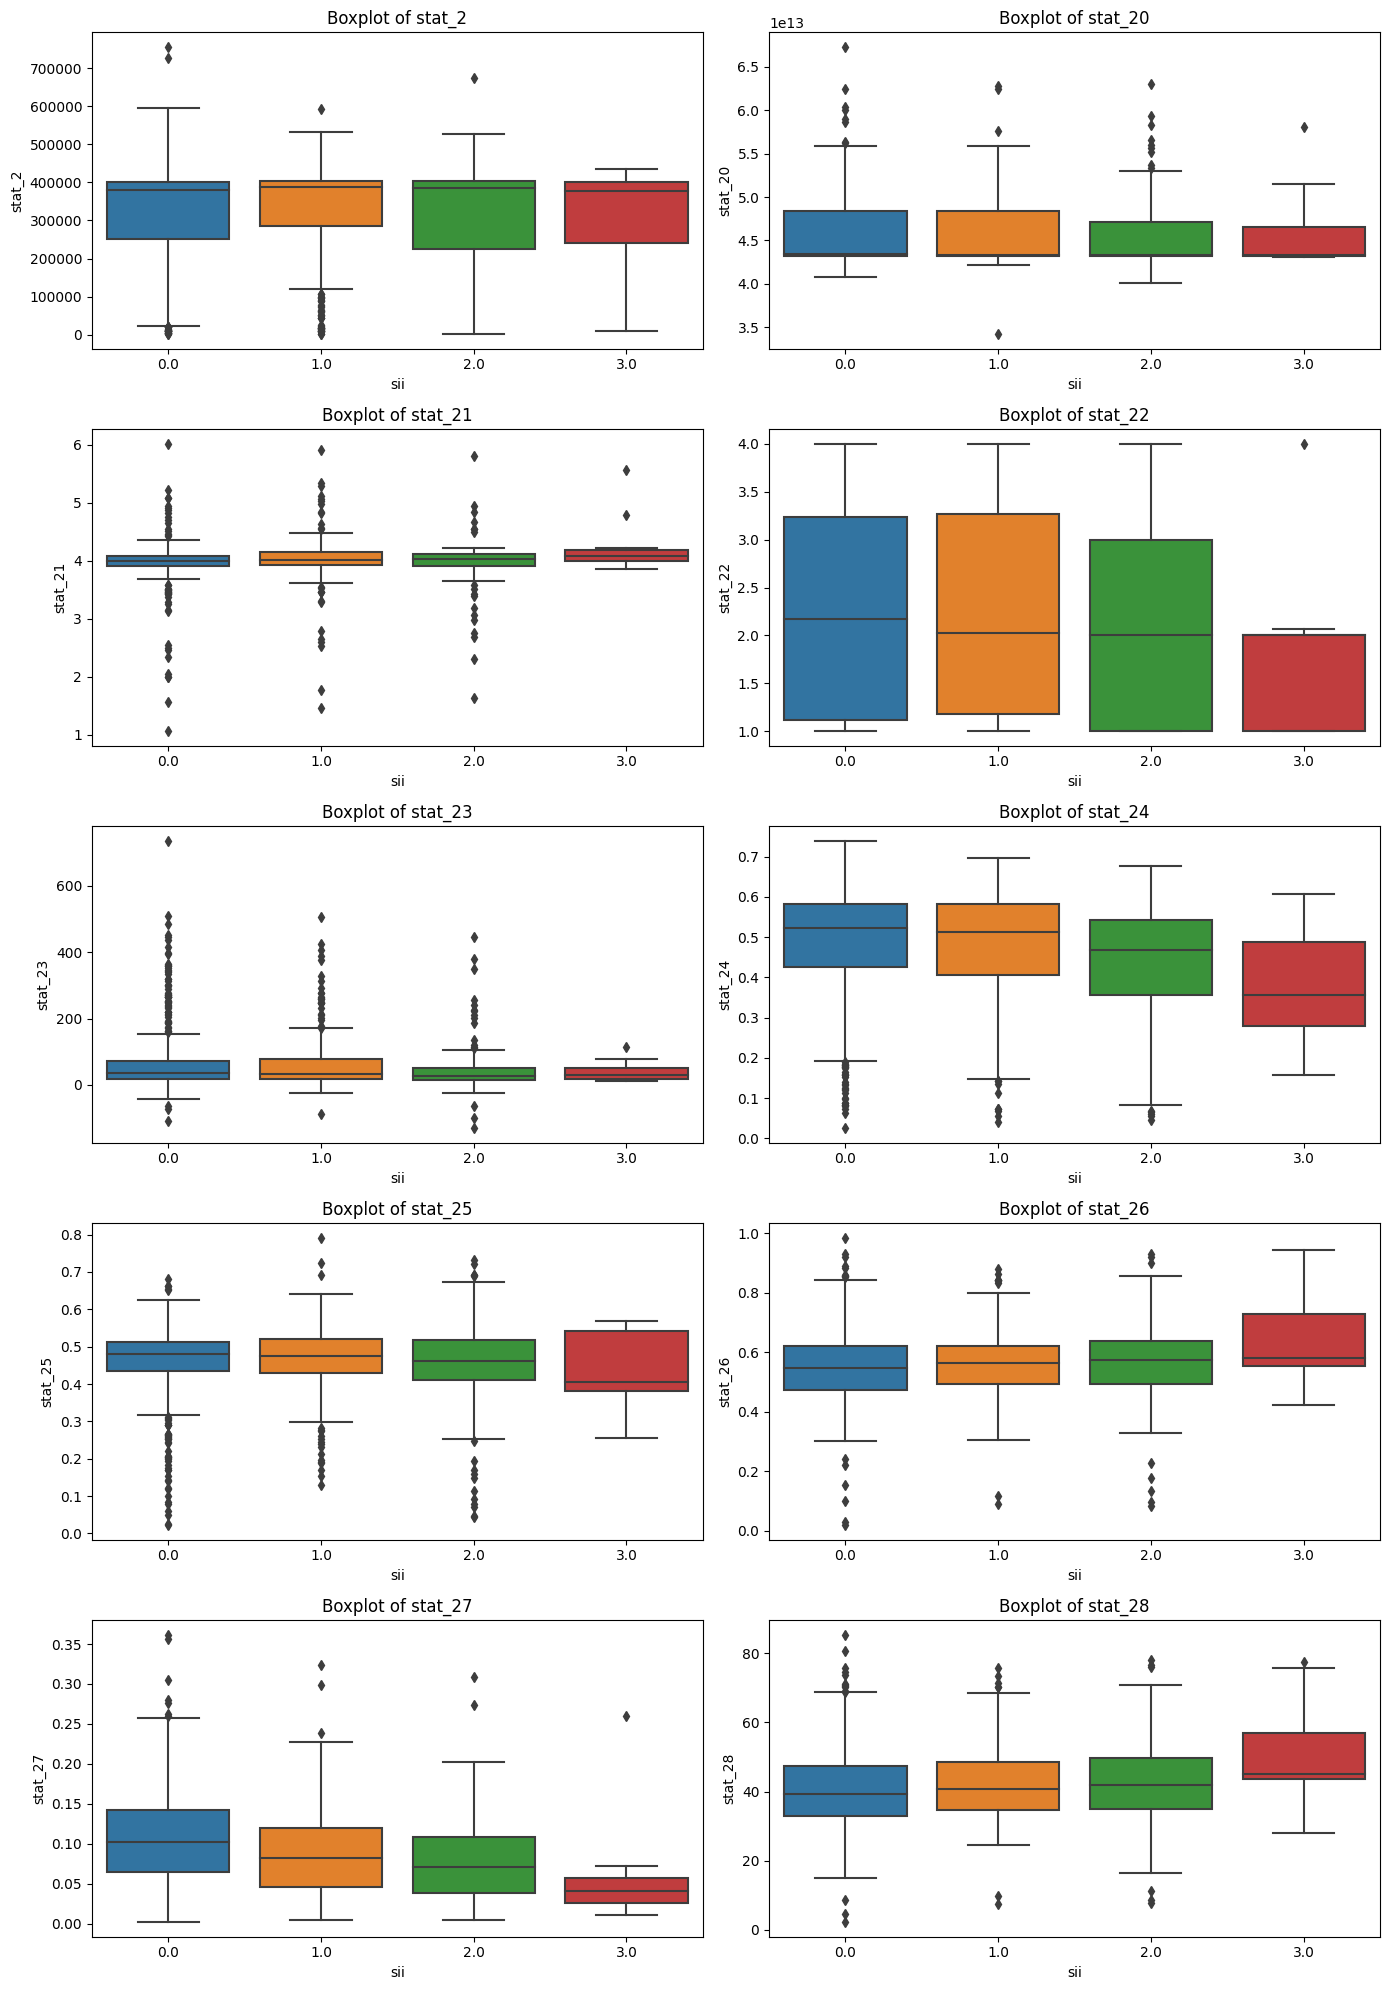

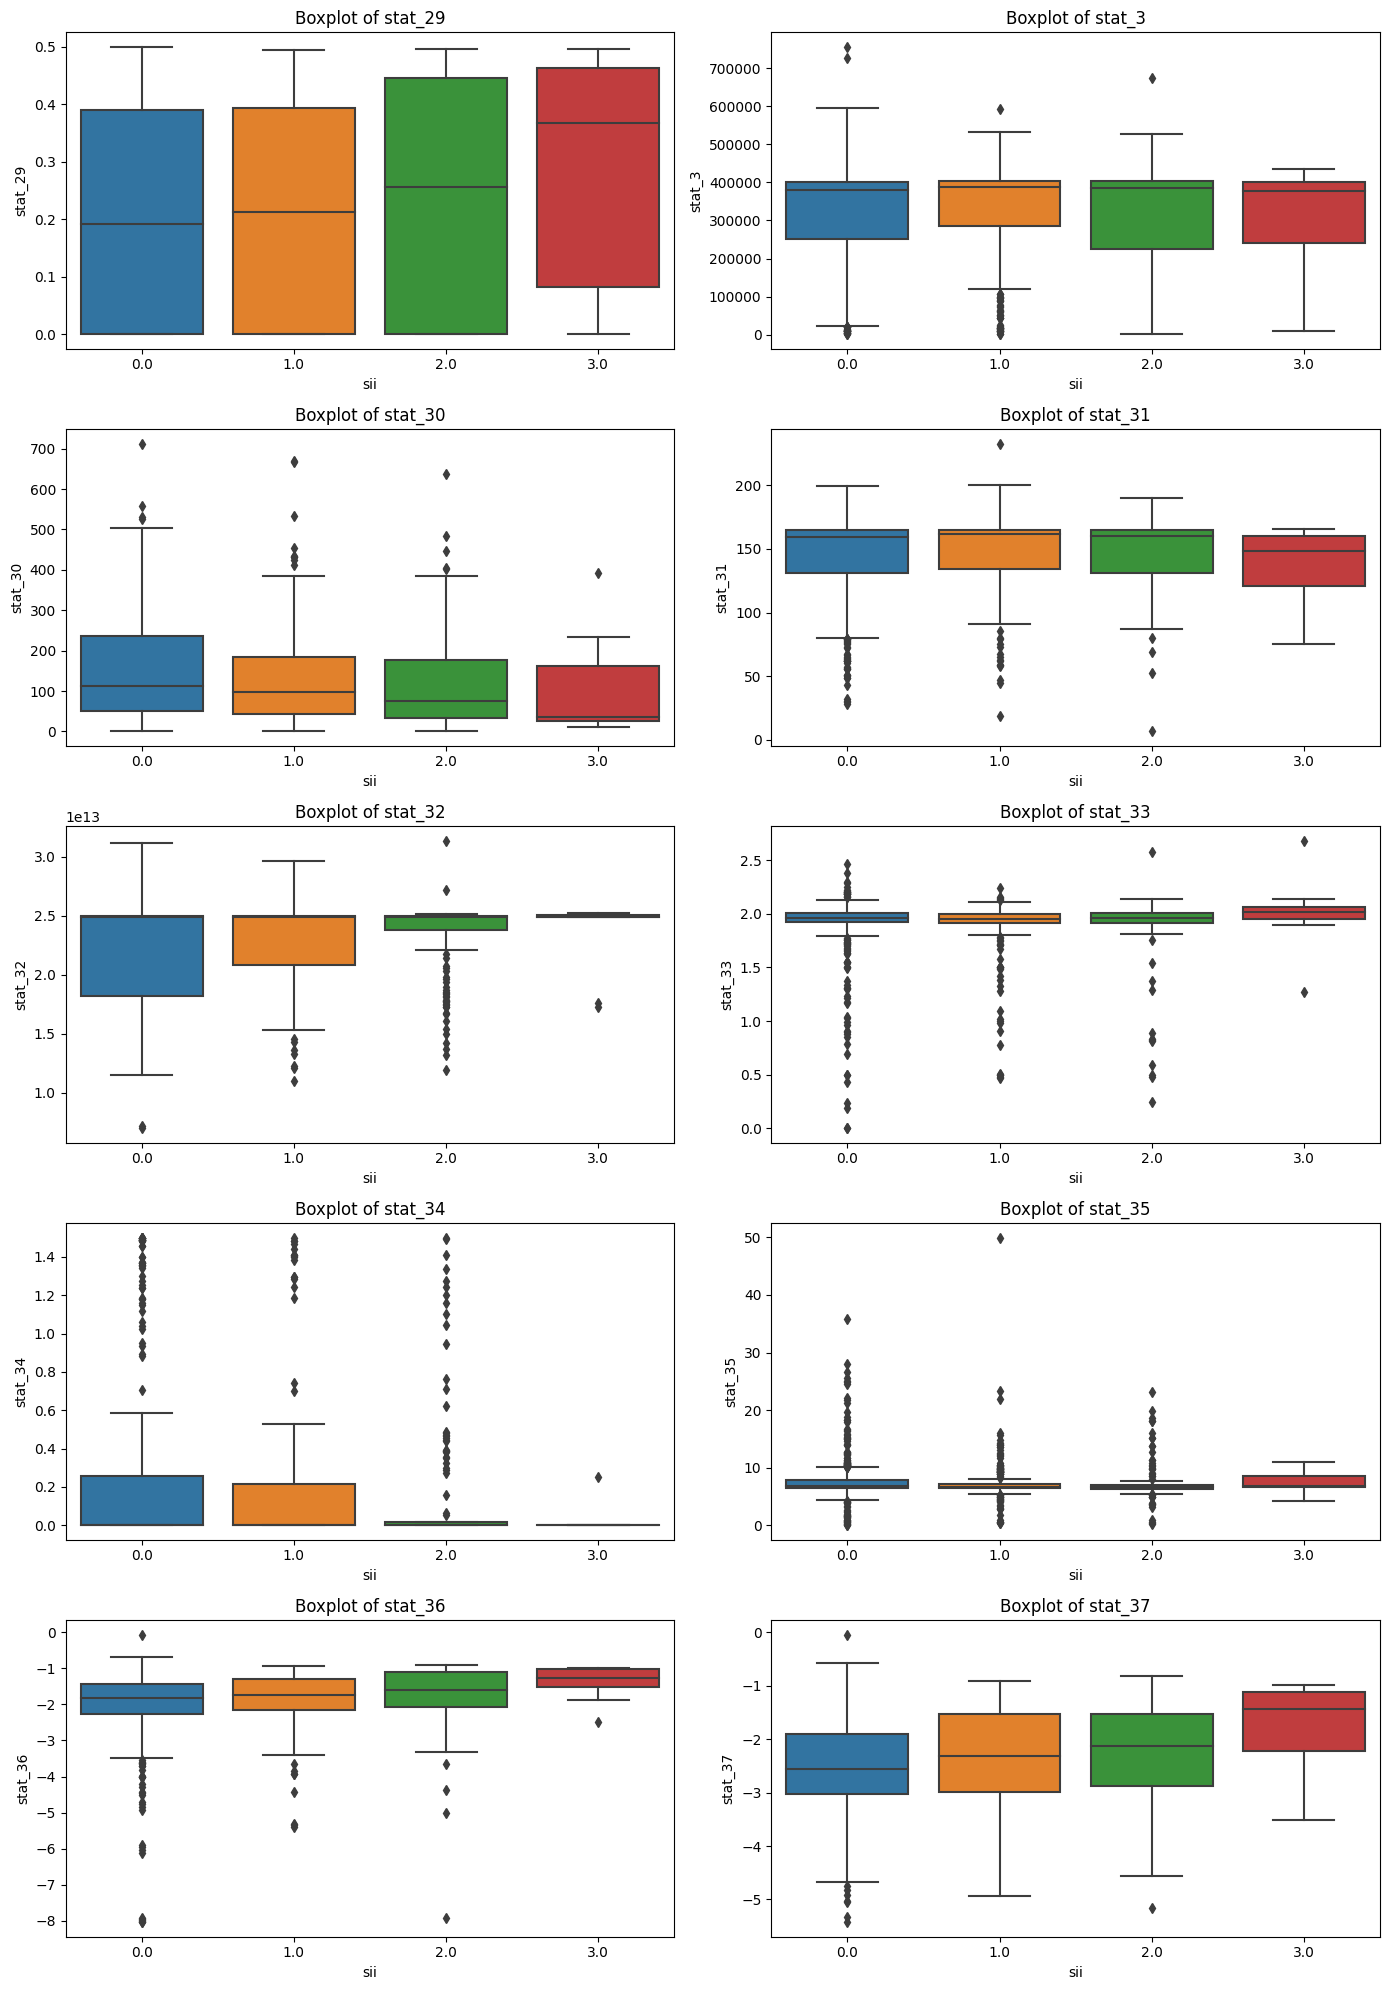

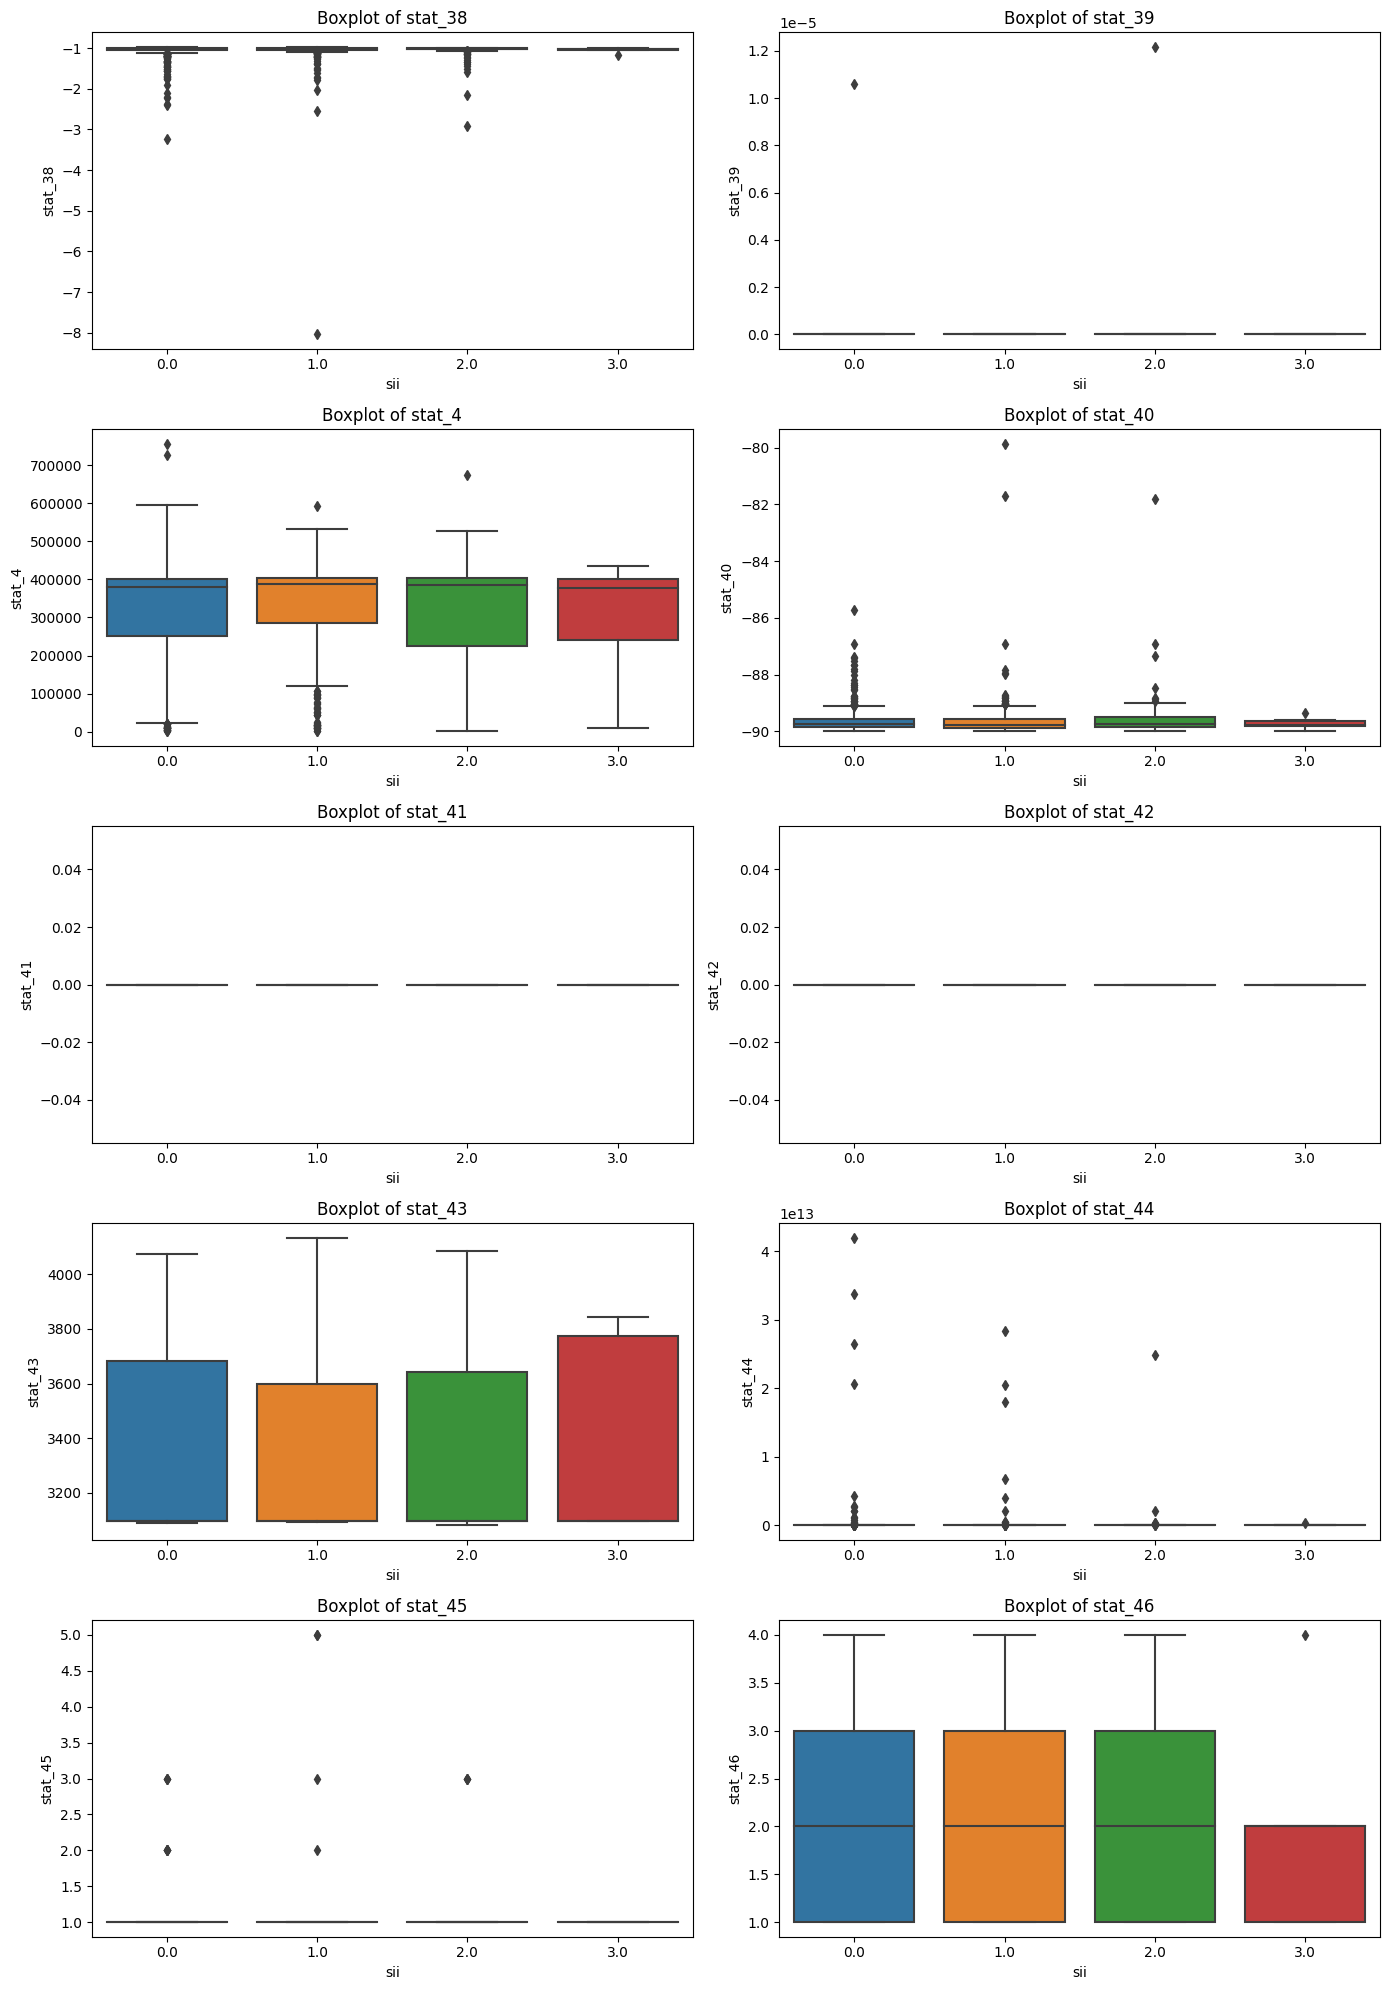

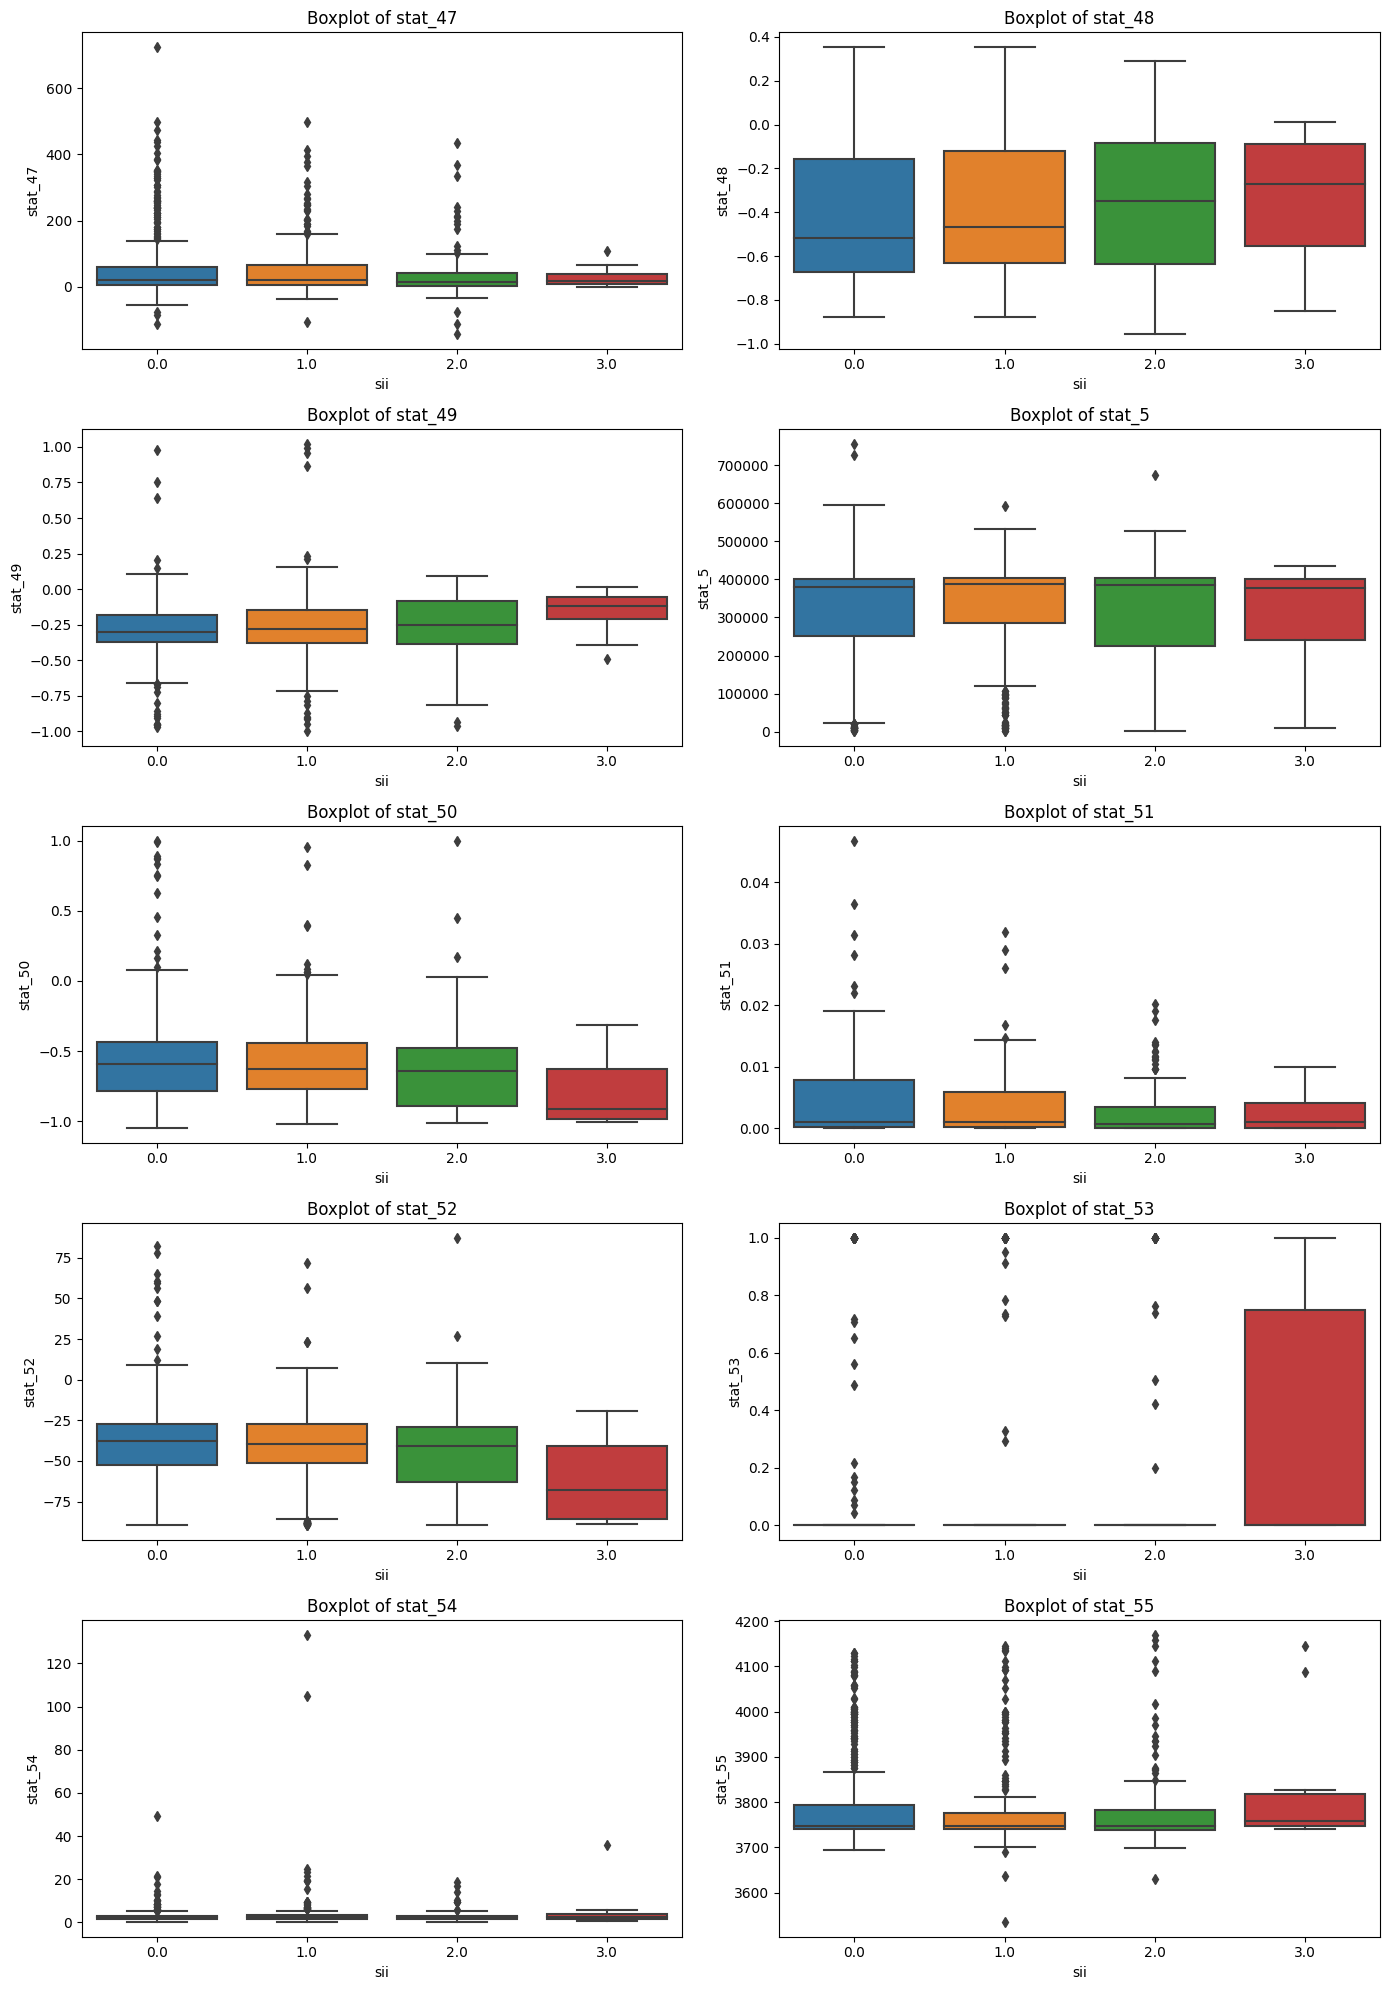

In [33]:
#boxplot of features(of csv)

num = 96 # 96-->time series features
num_per_batch = 10 
# As the no. of features to plot is too large so, ploting in batchwise to make the plot reada

for i in range(0,num, num_per_batch):
    end = i + num_per_batch
    batch_cols = numeric_cols[i:end]

    plt.figure(figsize = (14, 20))
    for j,col in enumerate(batch_cols,1):
        plt.subplot(5,2,j) # 5X2 subplots per batch
        sns.boxplot(x='sii', y=col, data=train)
        plt.title(f"Boxplot of {col}")
    
    plt.tight_layout()
    plt.show()

In [34]:

print(f"train{len(numeric_cols)}")
print(numeric_cols)
print(f"test{len(test_numeric_cols)}")
print(test_numeric_cols)



train144
['BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'Physical-BMI', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Height', 'Physical-Systolic_BP', 'Physical-Waist_Circumference', 'Physical-Weight', 'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'stat_0', 'stat_1', 'stat_10', 'stat_11', 'stat_12', 'sta

#### PROCESSING MISSING DATA

In [35]:
#FILLING MISSING DATA WITH MEDIAN (NUMERICAL FEATUES)

#train
imputer = SimpleImputer(strategy='median')
train[numeric_cols] = imputer.fit_transform(train[numeric_cols])

#test
test[test_numeric_cols] = imputer.fit_transform(test[test_numeric_cols])

#### LABEL ENCODING FOR CATEGORICAL FEATURES

In [36]:
#CATEGORICAL FEATURES

for col in categorical_cols:
    train[col] = train[col].fillna('missing')
    train[col] = train[col].astype('category')
    
    test[col] = test[col].fillna('missing')
    test[col] = test[col].astype('category') #uses less memory category dtype stores repeated values as int internally #makes operation easy(sorting,grouping) #LightGBM and XGBoost, work better with categorical features when the dtype is explicitly set to category

#LABEL ENCODING

le = LabelEncoder()

#train
for col in categorical_cols:
    train[col] = le.fit_transform(train[col]).astype(int)
#test
for col in test_categorical_cols:
     test[col] = le.transform(test[col]).astype(int)


#### FEATURE SCALLING

In [37]:
x = train.drop(['sii'], axis = 1)
y = train['sii']

# FEATURE SCALLING 

scaler = StandardScaler()
    #train
x[numeric_cols] = scaler.fit_transform(x[numeric_cols])
    #test
test[numeric_cols] = scaler.transform(test[numeric_cols])



In [38]:
#Spliting training and validation set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## BUILDING MODEL 

In [39]:
#PARAMETERS
lgb_params = {
    'lambda_l1': 1.84987772740316, 
    'lambda_l2': 2.74799424176787, 
    'num_leaves': 170, 
    'feature_fraction': 0.6557732374612563, 
    'bagging_fraction': 0.5511820667548543, 
    'bagging_freq': 3, 
    'min_child_samples': 94
}

In [40]:
model = LGBMClassifier(**lgb_params, verbosity = -1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_test)

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test,y_val_pred)
print(f"Validation Accuracy :{accuracy}")
cm = confusion_matrix(y_test,y_val_pred)
print(cm)

accuracy = accuracy_score(y_train,y_train_pred)
print(f"Train Accuracy :{accuracy}")
cm = confusion_matrix(y_train,y_train_pred)
print(cm)

Validation Accuracy :0.6240875912408759
[[295  32   9   0]
 [ 79  37  15   0]
 [ 35  27  10   0]
 [  0   4   5   0]]
Train Accuracy :0.7518281535648994
[[1183   55   20    0]
 [ 252  320   26    1]
 [ 118   50  138    0]
 [   4    5   12    4]]
